In [ ]:
from sportsdataverse.nfl.nfl_loaders import load_nfl_depth_charts

depth_df = load_nfl_depth_charts(seasons=list(range(2018, 2025)), return_as_pandas=False)  # stay in Polars
depth_df = depth_df.to_pandas(use_pyarrow_extension_array=False)  # convert manually
depth_df.tail(10)


In [ ]:
depth_df["depth_position"].value_counts().sort_values(ascending=False)


In [ ]:
depth_df[
    depth_df["full_name"].str.lower().str.strip() == "quincy williams"
][["season", "week", "club_code", "position", "depth_position", "depth_team"]].drop_duplicates()



In [ ]:
print(depth_df.columns.tolist())

In [ ]:
bijan_players = depth_df[depth_df["first_name"].str.lower() == "bijan"]

print(bijan_players)



In [ ]:
from nfl_data_py import import_draft_picks

# Load all draft picks
draft_df = import_draft_picks(list(range(2010, 2025)))

# Preview columns and first few rows

draft_df


In [ ]:
from sportsdataverse.nfl.nfl_loaders import load_nfl_rosters

# Load 2025 rosters
rosters_2025 = load_nfl_rosters(seasons=list(range(2018, 2025)), return_as_pandas=True)

# Filter for Stefon Diggs
diggs = rosters_2025[
    (rosters_2025["first_name"].str.lower() == "stefon") &
    (rosters_2025["last_name"].str.lower() == "diggs")
]

print(diggs.columns.tolist())

In [ ]:
from sportsdataverse.nfl.nfl_loaders import load_nfl_rosters

# Load rosters from 2018 to 2025
rosters_all = load_nfl_rosters(seasons=list(range(2018, 2026)), return_as_pandas=True)

# Filter for Travis Hunter (example)
hunter = rosters_all[
    (rosters_all["first_name"].str.lower() == "travis") &
    (rosters_all["last_name"].str.lower() == "hunter")
]

print(hunter[["full_name", "team", "position", "season"]])


In [ ]:
from nfl_data_py import import_schedules

schedule_df = import_schedules(list(range(2018, 2025))) # Include any years you want
print(schedule_df.columns.tolist())
print(schedule_df.head())


In [ ]:
from nfl_data_py import import_draft_values

draft_values = import_draft_values()
print(draft_values.columns.tolist())
print(draft_values.head())


In [ ]:
from nfl_data_py import import_injuries

injuries_2024 = import_injuries(list(range(2018, 2025)))

In [ ]:
print(injuries_2024.columns.tolist())

# Filter for a specific player (e.g., Stefon Diggs)
injuries_2024[injuries_2024['full_name'].str.contains("stefon diggs", case=False)]


In [ ]:
from nfl_data_py import import_snap_counts
snaps = import_snap_counts(list(range(2018, 2025)))
snaps

In [ ]:
from nfl_data_py import import_pbp_data
pbp = import_pbp_data(list(range(2018, 2025)))
pbp.head()
print(pbp.columns.tolist())

In [ ]:
results = (
    pbp.groupby("game_id")
    .agg({
        "home_team": "first",
        "away_team": "first",
        "result": "max"  # Final point difference for home team
    })
    .reset_index()
)

print(results.head())

In [ ]:
final_scores = (
    pbp.groupby("game_id")
    .agg({
        "home_team": "first",
        "away_team": "first",
        "home_score": "max",
        "away_score": "max"
    })
    .reset_index()
)

print(final_scores.head())


In [ ]:
final_scores["winner"] = final_scores.apply(
    lambda row: row["home_team"] if row["home_score"] > row["away_score"]
    else row["away_team"] if row["away_score"] > row["home_score"]
    else "TIE", axis=1
)
final_scores


In [ ]:
pbp_offense = pbp[pbp["posteam"].notna()]

# Group by game and team
team_game_stats = pbp_offense.groupby(["game_id", "posteam"]).agg(
    plays=("play_id", "count"),
    total_yards=("yards_gained", "sum"),
    total_epa=("epa", "sum"),
    epa_per_play=("epa", "mean"),
    pass_plays=("pass_attempt", "sum"),
    rush_plays=("rush_attempt", "sum"),
    pass_yards=("passing_yards", "sum"),
    rush_yards=("rushing_yards", "sum"),
    third_down_conversions=("third_down_converted", "sum"),
    third_down_failures=("third_down_failed", "sum"),
    fourth_down_conversions=("fourth_down_converted", "sum"),
    fourth_down_failures=("fourth_down_failed", "sum"),
    penalties=("penalty", "sum"),
    interceptions=("interception", "sum"),
    fumbles_lost=("fumble_lost", "sum")
).reset_index()

# Compute derived columns
team_game_stats["third_down_attempts"] = (
    team_game_stats["third_down_conversions"] + team_game_stats["third_down_failures"]
)
team_game_stats["fourth_down_attempts"] = (
    team_game_stats["fourth_down_conversions"] + team_game_stats["fourth_down_failures"]
)
team_game_stats["turnovers"] = (
    team_game_stats["interceptions"] + team_game_stats["fumbles_lost"]
)
team_game_stats["yards_per_play"] = team_game_stats["total_yards"] / team_game_stats["plays"]

print(team_game_stats.head())

In [ ]:
# Filter to only plays with a defense team listed
pbp_defense = pbp[pbp["defteam"].notna()]

# Group by game and defensive team
team_def_stats = pbp_defense.groupby(["game_id", "defteam"]).agg(
    plays_defended=("play_id", "count"),
    yards_allowed=("yards_gained", "sum"),
    epa_allowed=("epa", "sum"),
    epa_per_play_allowed=("epa", "mean"),
    passes_defended=("pass_attempt", "sum"),
    rushes_defended=("rush_attempt", "sum"),
    pass_yards_allowed=("passing_yards", "sum"),
    rush_yards_allowed=("rushing_yards", "sum"),
    third_down_conversions_allowed=("third_down_converted", "sum"),
    third_down_failures_forced=("third_down_failed", "sum"),
    fourth_down_conversions_allowed=("fourth_down_converted", "sum"),
    fourth_down_failures_forced=("fourth_down_failed", "sum"),
    penalties_committed=("penalty", "sum"),
    interceptions_forced=("interception", "sum"),
    fumbles_recovered=("fumble_lost", "sum")  # approximation; may need refining
).reset_index()

# Derived metrics
team_def_stats["third_down_attempts_faced"] = (
    team_def_stats["third_down_conversions_allowed"] + team_def_stats["third_down_failures_forced"]
)
team_def_stats["fourth_down_attempts_faced"] = (
    team_def_stats["fourth_down_conversions_allowed"] + team_def_stats["fourth_down_failures_forced"]
)
team_def_stats["turnovers_forced"] = (
    team_def_stats["interceptions_forced"] + team_def_stats["fumbles_recovered"]
)
team_def_stats["yards_per_play_allowed"] = (
    team_def_stats["yards_allowed"] / team_def_stats["plays_defended"]
)

print(team_def_stats.head())

In [ ]:
import numpy as np
pbp_offense = pbp[pbp["posteam"].notna()].copy()
# Explosive plays: gains > 20 yards (rush or pass)
pbp_offense["explosive_play"] = ((pbp_offense["passing_yards"] > 20) | (pbp_offense["rushing_yards"] > 20)).astype(int)

# Dropbacks = pass_attempt + sacks
pbp_offense["dropbacks"] = pbp_offense["qb_dropback"]

# Red zone indicator: yardline_100 <= 20 and touchdown scored
pbp_offense["red_zone_td"] = ((pbp_offense["yardline_100"] <= 20) & (pbp_offense["touchdown"] == 1)).astype(int)

# Group again and compute the new metrics
offensive_addons = pbp_offense.groupby(["game_id", "posteam"]).agg(
    explosive_plays=("explosive_play", "sum"),
    red_zone_tds=("red_zone_td", "sum"),
    sacks=("sack", "sum"),
    dropbacks=("dropbacks", "sum"),
    avg_starting_field_position=("yardline_100", "mean"),
    total_penalties=("penalty", "sum")
).reset_index()

# Calculate derived features
offensive_addons["sack_rate"] = offensive_addons["sacks"] / offensive_addons["dropbacks"].replace(0, np.nan)
offensive_addons["penalties_per_play"] = offensive_addons["total_penalties"] / team_game_stats["plays"]

# Merge with the main team_game_stats DataFrame
team_game_stats = team_game_stats.merge(offensive_addons, on=["game_id", "posteam"], how="left")
team_game_stats

In [ ]:
import numpy as np

pbp_defense = pbp[pbp["defteam"].notna()].copy()

# Explosive plays allowed
pbp_defense["explosive_play_allowed"] = (
    (pbp_defense["passing_yards"] > 20) | (pbp_defense["rushing_yards"] > 20)
).astype(int)

# Dropbacks faced = pass_attempt + sacks
pbp_defense["dropbacks_faced"] = pbp_defense["qb_dropback"]

# Red zone TDs allowed
pbp_defense["red_zone_td_allowed"] = (
    (pbp_defense["yardline_100"] <= 20) & (pbp_defense["touchdown"] == 1)
).astype(int)

# Group by game and defensive team
team_def_stats = pbp_defense.groupby(["game_id", "defteam"]).agg(
    explosive_plays_allowed=("explosive_play_allowed", "sum"),
    red_zone_tds_allowed=("red_zone_td_allowed", "sum"),
    sacks_made=("sack", "sum"),
    dropbacks_faced=("dropbacks_faced", "sum"),
    avg_starting_field_position_allowed=("yardline_100", "mean"),
    total_penalties_by_defense=("penalty", "sum")
).reset_index()

# Derived defensive metrics
team_def_stats["sack_rate_def"] = team_def_stats["sacks_made"] / team_def_stats["dropbacks_faced"].replace(0, np.nan)
team_def_stats["penalties_per_play_def"] = team_def_stats["total_penalties_by_defense"] / team_def_stats["dropbacks_faced"].replace(0, np.nan)

team_def_stats.head()

In [ ]:
# Step 1: Get game info — home vs away team per game
games_df = pbp[['game_id', 'home_team', 'away_team']].drop_duplicates()

# Step 2: Merge in offensive stats for both teams
off_home = team_game_stats.rename(columns=lambda x: f'home_{x}' if x not in ['game_id', 'posteam'] else x)
off_home = off_home.rename(columns={"posteam": "home_team"})

off_away = team_game_stats.rename(columns=lambda x: f'away_{x}' if x not in ['game_id', 'posteam'] else x)
off_away = off_away.rename(columns={"posteam": "away_team"})

game_data = games_df.merge(off_home, on=["game_id", "home_team"])
game_data = game_data.merge(off_away, on=["game_id", "away_team"])

# Step 3: Merge in defensive stats
def_home = team_def_stats.rename(columns=lambda x: f'home_{x}' if x not in ['game_id', 'defteam'] else x)
def_home = def_home.rename(columns={"defteam": "home_team"})

def_away = team_def_stats.rename(columns=lambda x: f'away_{x}' if x not in ['game_id', 'defteam'] else x)
def_away = def_away.rename(columns={"defteam": "away_team"})

game_data = game_data.merge(def_home, on=["game_id", "home_team"])
game_data = game_data.merge(def_away, on=["game_id", "away_team"])

game_data.head()

In [ ]:
# Merge scores from schedule_df into game_data using game_id
game_data = game_data.merge(
    schedule_df[["game_id", "home_score", "away_score"]],
    on="game_id",
    how="left"
)
game_data

In [ ]:
# Step 1: Filter to dropbacks
'''qb_plays = pbp[(pbp["qb_dropback"] == 1)].copy()

# Fallback QB identity: use rusher for scrambles
qb_plays["qb_name"] = qb_plays["passer_player_name"].fillna(qb_plays["rusher_player_name"])

# Step 2: Standardize QB name formatting
qb_plays["qb_name"] = qb_plays["qb_name"].str.strip().str.replace(r"\s+", " ", regex=True)
qb_plays["qb_name"] = qb_plays["qb_name"].str.replace("Aa.Rodgers", "A.Rodgers")
qb_plays = qb_plays[qb_plays["qb_name"].notna()]

# Step 3: Merge season + week if needed
if "season" not in qb_plays.columns or "week" not in qb_plays.columns:
    qb_plays = qb_plays.merge(schedule_df[["game_id", "season", "week"]], on="game_id", how="left")

# Step 4: Recency weighting
season_jump_factor = 1.25
season_min = qb_plays["season"].min()
qb_plays["season_index"] = qb_plays["season"] - season_min
qb_plays["recency_index"] = (season_jump_factor ** qb_plays["season_index"]) * qb_plays["week"]
max_recency = qb_plays["recency_index"].max()
qb_plays["recency_weight"] = qb_plays["recency_index"] / max_recency

# Step 5: Weighted EPA and cumulative sums
qb_plays["weighted_epa"] = qb_plays["epa"] * qb_plays["recency_weight"]
qb_plays = qb_plays.sort_values(["qb_name", "season", "week"])
qb_plays["cum_weighted_epa"] = qb_plays.groupby("qb_name")["weighted_epa"].cumsum().shift(1)
qb_plays["cum_weighted_dropbacks"] = qb_plays.groupby("qb_name")["recency_weight"].cumsum().shift(1)
qb_plays["cum_raw_dropbacks"] = qb_plays.groupby("qb_name")["play_id"].cumcount()
qb_plays["weighted_epa_per_dropback"] = qb_plays["cum_weighted_epa"] / qb_plays["cum_weighted_dropbacks"]

# Step 6: Draft-based shrinkage targets
replacement_level = qb_plays["weighted_epa_per_dropback"].mean() - 0.1
draft_target_adjustments = {
    1: .05, 2: .00, 3: -.03, 4: -.05, 5: -.07, 6: -.10, 7: -.13, "UDFA": -0.20
}

# Step 7: Deduplicate draft data cleanly
draft_df["round_clean"] = draft_df["round"].fillna("UDFA")
draft_df["round_sort_key"] = draft_df["round"].fillna(999)

draft_df_trimmed = (
    draft_df[["gsis_id", "round_clean", "round_sort_key"]]
    .sort_values("round_sort_key")
    .drop_duplicates(subset="gsis_id", keep="first")
    .rename(columns={"round_clean": "round"})
    .copy()
)

# Step 8: Merge draft round and compute draft target
qb_plays = qb_plays.merge(
    draft_df_trimmed,
    left_on="passer_player_id",
    right_on="gsis_id",
    how="left"
)
qb_plays["round"] = qb_plays["round"].fillna("UDFA")
qb_plays["draft_target"] = qb_plays["round"].apply(lambda r: draft_target_adjustments.get(r, replacement_level))

# Step 9: Shrink adjusted EPA toward draft target
prior_weight = 100
qb_plays["adjusted_epa_per_dropback"] = (
    (qb_plays["weighted_epa_per_dropback"] * qb_plays["cum_weighted_dropbacks"]
     + qb_plays["draft_target"] * prior_weight)
    / (qb_plays["cum_weighted_dropbacks"] + prior_weight)
)

# Step 10: Keep last stat line per QB per game
qb_weekly_stats = qb_plays.sort_values("week").drop_duplicates(subset=["game_id", "qb_name"], keep="last")

# Final table
qb_stats_final = qb_weekly_stats[[
    "game_id", "season", "week", "qb_name",
    "weighted_epa_per_dropback",
    "draft_target",
    "adjusted_epa_per_dropback",
    "cum_weighted_dropbacks",
    "cum_raw_dropbacks"
]]'''


In [ ]:
# Replace these names with any QBs you're interested in
'''target_qbs = ["J.Herbert", "B.Young", "C.Williams"]

# Filter for those QBs
recent_qb_scores = qb_stats_final[qb_stats_final["qb_name"].isin(target_qbs)]

# Sort so each QB's most recent stat is on top
recent_qb_scores = recent_qb_scores.sort_values(["qb_name", "season", "week"], ascending=[True, False, False])
#comment
# Drop duplicates to get most recent row per QB
most_recent_scores = recent_qb_scores.drop_duplicates(subset="qb_name", keep="first")

# Display
most_recent_scores[["qb_name", "season", "week", "adjusted_epa_per_dropback", "cum_raw_dropbacks"]]'''

In [ ]:
'''# Show sample plays where the QB scrambled
pbp[pbp["qb_scramble"] == 1][
    ["game_id", "play_id", "posteam", "defteam", "qtr", "down",
     "yardline_100", "qb_scramble", "epa", "yards_gained", "passer_player_name", "rusher_player_name", "play_type", "desc", "qb_dropback"]
].head(10)
'''

In [ ]:
# --- QB Rushing Value (Designed Runs Only, with Shrinkage) ---
'''
# Step 1: Filter to designed QB runs (exclude dropbacks and scrambles)
qb_runs = pbp[
    (pbp["qb_dropback"] == 0) &  # not a dropback
    (pbp["rusher_player_id"].notna())
].copy()

# Step 2: Limit to players who are known QBs
known_qbs = pbp["passer_player_id"].dropna().unique()
qb_runs = qb_runs[qb_runs["rusher_player_id"].isin(known_qbs)]

# Step 3: Assign QB name
qb_runs["qb_name"] = qb_runs["rusher_player_name"].str.strip().str.replace(r"\s+", " ", regex=True)

# Step 4: Merge season + week if needed
if "season" not in qb_runs.columns or "week" not in qb_runs.columns:
    qb_runs = qb_runs.merge(schedule_df[["game_id", "season", "week"]], on="game_id", how="left")

# Step 5: Recency weighting
season_jump_factor = 1.25
season_min = qb_runs["season"].min()
qb_runs["season_index"] = qb_runs["season"] - season_min
qb_runs["recency_index"] = (season_jump_factor ** qb_runs["season_index"]) * qb_runs["week"]
qb_runs["recency_weight"] = qb_runs["recency_index"] / qb_runs["recency_index"].max()

qb_rush_weekly = qb_runs.copy()
qb_rush_weekly["weighted_epa"] = qb_rush_weekly["epa"] * qb_rush_weekly["recency_weight"]
qb_rush_weekly = qb_rush_weekly.sort_values(["qb_name", "season", "week", "game_id", "play_id"])

# Shift the cumulative sums so current play is excluded
qb_rush_weekly["cum_qb_rush_plays"] = (
    qb_rush_weekly.groupby("qb_name")["play_id"].cumcount().shift(1).fillna(0).astype(int)
)
qb_rush_weekly["cum_weighted_epa"] = (
    qb_rush_weekly.groupby("qb_name")["weighted_epa"].cumsum().shift(1).fillna(0)
)
qb_rush_weekly["cum_recency_weight"] = (
    qb_rush_weekly.groupby("qb_name")["recency_weight"].cumsum().shift(1).fillna(0)
)

qb_rush_weekly_stats = qb_rush_weekly.groupby(["qb_name", "season", "week"]).agg(
    qb_rush_plays=("play_id", "count"),
    cum_qb_rush_plays=("cum_qb_rush_plays", "max"),
    total_weighted_epa=("cum_weighted_epa", "max"),
    total_recency_weight=("cum_recency_weight", "max")
).reset_index()

qb_rush_weekly_stats["avg_rush_epa"] = (
    qb_rush_weekly_stats["total_weighted_epa"] / qb_rush_weekly_stats["total_recency_weight"]
)

qb_rush_weekly_stats["avg_rush_epa"] = qb_rush_weekly_stats["total_weighted_epa"] / qb_rush_weekly_stats["total_recency_weight"]

# Step 8: Shrink toward replacement
rush_replacement_level = qb_rush_weekly_stats["avg_rush_epa"].mean() - 0.05
rush_prior_weight = 100

qb_rush_weekly_stats["shrunken_rush_epa"] = (
    (qb_rush_weekly_stats["avg_rush_epa"] * qb_rush_weekly_stats["total_recency_weight"]
     + rush_replacement_level * rush_prior_weight)
    / (qb_rush_weekly_stats["total_recency_weight"] + rush_prior_weight)
)
'''

In [ ]:
# --- Combine QB Passing and Rushing Metrics with Shrinkage ---
'''
# Merge passing and rushing stats
qb_value = qb_stats_final.merge(
    qb_rush_weekly_stats[["qb_name", "season", "week", "qb_rush_plays", "cum_qb_rush_plays", "shrunken_rush_epa"]],
    on=["qb_name", "season", "week"],
    how="left"
)

# Fill missing rush stats
qb_value["qb_rush_plays"] = qb_value["qb_rush_plays"].fillna(0)
qb_value["shrunken_rush_epa"] = qb_value["shrunken_rush_epa"].fillna(rush_replacement_level)
qb_value["cum_qb_rush_plays"] = qb_value.groupby("qb_name")["cum_qb_rush_plays"].ffill().fillna(0)

# Optional: still compute total plays and EPA (for context)
qb_value["total_plays"] = qb_value["cum_raw_dropbacks"] + qb_value["cum_qb_rush_plays"]
qb_value["total_epa"] = (
    qb_value["adjusted_epa_per_dropback"] * qb_value["cum_raw_dropbacks"]
    + qb_value["shrunken_rush_epa"] * qb_value["qb_rush_plays"]
)
qb_value["epa_per_play"] = qb_value["total_epa"] / qb_value["total_plays"]

# 🎯 NEW: Weighted EPA blend instead of total-per-play
rush_weight = 0.25  # Adjust this as needed
qb_value["epa_blended"] = (
    qb_value["adjusted_epa_per_dropback"] * (1 - rush_weight)
    + qb_value["shrunken_rush_epa"] * rush_weight
)


# Preview top QBs using the blended EPA
qb_value_sorted = qb_value.sort_values("epa_blended", ascending=False)
qb_value_sorted[[
    "qb_name", "adjusted_epa_per_dropback", "shrunken_rush_epa",
    "epa_blended", "cum_raw_dropbacks", "cum_qb_rush_plays", "total_plays"
]].head(10)
'''

In [ ]:
'''latest_qb_values = qb_value.sort_values(["qb_name", "season", "week"]).drop_duplicates(
    subset="qb_name", keep="last"
)

# Then show top 10 by overall EPA per play
top_qbs = latest_qb_values.sort_values("epa_blended", ascending=False).head(50)

display(top_qbs[[
    "qb_name", "adjusted_epa_per_dropback", "shrunken_rush_epa",
    "epa_blended", "cum_raw_dropbacks", "cum_qb_rush_plays", "total_plays"
]])
'''

In [ ]:
# List the QBs you want to inspect
'''qbs_to_view = ["J.Daniels", "B.Nix", "G.Smith"] #comment

# Filter and show their metrics
latest_qb_values[latest_qb_values["qb_name"].isin(qbs_to_view)][[
    "qb_name", "adjusted_epa_per_dropback", "shrunken_rush_epa",
    "epa_blended", "cum_raw_dropbacks", "qb_rush_plays", "total_plays"
]]
'''

In [ ]:
# Rename roster player ID to match PBP field
'''rosters_2025_with_rusher_id = rosters_2025.rename(columns={"gsis_id": "rusher_player_id"})

'''

In [ ]:
# Filter rush attempts
'''rb_plays = pbp[pbp["rush_attempt"] == 1].copy()

# Merge using player ID (avoids duplicate names)
rb_plays = rb_plays.merge(
    rosters_2025_with_rusher_id[["rusher_player_id", "position", "full_name"]],
    on="rusher_player_id",
    how="left"
)

# Filter only RBs
rb_plays = rb_plays[rb_plays["position"] == "RB"]

# Optional: use full_name as cleaned name
rb_plays["rb_name"] = rb_plays["full_name"].fillna(rb_plays["rusher_player_name"])
'''


In [ ]:
# Season-jump recency weightinb
''' season_jump_factor = 2
season_min = rb_plays["season"].min()
rb_plays["season_index"] = rb_plays["season"] - season_min
rb_plays["recency_index"] = (season_jump_factor ** rb_plays["season_index"]) * rb_plays["week"]

# Normalize to [0, 1]
max_recency = rb_plays["recency_index"].max()
rb_plays["recency_weight"] = rb_plays["recency_index"] / max_recency


# Weighted EPA
rb_plays["weighted_epa"] = rb_plays["epa"] * rb_plays["recency_weight"]

# Cumulative metrics
rb_plays = rb_plays.sort_values(["rb_name", "season", "week"])
rb_plays["cum_weighted_epa"] = rb_plays.groupby("rb_name")["weighted_epa"].cumsum().shift(1).fillna(0)
rb_plays["cum_weighted_rushes"] = rb_plays.groupby("rb_name")["recency_weight"].cumsum().shift(1).fillna(0)
rb_plays["cum_raw_rushes"] = rb_plays.groupby("rb_name")["play_id"].cumcount().shift(1).fillna(0).astype(int)


# EPA per rush
rb_plays["weighted_epa_per_rush"] = rb_plays["cum_weighted_epa"] / rb_plays["cum_weighted_rushes"]

# Shrink toward replacement RB
replacement_level_rb = rb_plays["weighted_epa_per_rush"].mean() - 0.05
prior_weight_rb = 300
rb_plays["adjusted_epa_per_rush"] = (
    (rb_plays["weighted_epa_per_rush"] * rb_plays["cum_weighted_rushes"] + replacement_level_rb * prior_weight_rb)
    / (rb_plays["cum_weighted_rushes"] + prior_weight_rb)
)
'''


In [ ]:
'''# Step 1: Keep only the last stat line per RB per game
rb_weekly_stats = rb_plays.sort_values("week").drop_duplicates(subset=["game_id", "rb_name"], keep="last")

# Step 2: Get the latest stat line for each RB
latest_rb_stats = rb_weekly_stats.sort_values(["rb_name", "season", "week"]).drop_duplicates("rb_name", keep="last")

# Step 3: Sort by adjusted EPA per rush and show top 10
top_10_rbs = latest_rb_stats.sort_values("adjusted_epa_per_rush", ascending=False).head(10)

# Step 4: Display selected columns
display(top_10_rbs[["rb_name", "adjusted_epa_per_rush", "cum_raw_rushes", "season", "week"]])
# Create rb_stats_final so we can combine later with receiving
rb_stats_final = rb_plays.sort_values(["rb_name", "season", "week"]).drop_duplicates(
    subset=["rb_name", "season", "week"], keep="last"
)[["rb_name", "adjusted_epa_per_rush", "cum_raw_rushes", "season", "week"]]
'''



In [ ]:
'''def get_rb_adjusted_epa(rb_name_query):
    result = rb_plays[rb_plays["rb_name"] == rb_name_query]
    if result.empty:
        print(f"No data found for {rb_name_query}")
        return None
    # Show the latest stat line
    latest = result.sort_values(["season", "week"]).iloc[-1]
    print(f"{rb_name_query} — Adjusted EPA/rush: {latest['adjusted_epa_per_rush']:.4f} on {latest['cum_raw_rushes']} rushes")
    return latest[["season", "week", "adjusted_epa_per_rush", "cum_raw_rushes"]]

# Example usage:
get_rb_adjusted_epa("Rachaad White")'''

In [ ]:
'''# --- RB Receiving Value: Recency-Weighted Yards Per Target (Shrinked, Weekly with forward fill) ---

# Step 1: Filter pass plays where RB is the receiver
rb_receives = pbp[
    (pbp["pass_attempt"] == 1) & (pbp["receiver_player_id"].notna())
].copy()

# Step 2: Merge RB position data
rb_receives = rb_receives.merge(
    rosters_2025_with_rusher_id[["rusher_player_id", "position", "full_name"]].rename(columns={"rusher_player_id": "receiver_player_id"}),
    on="receiver_player_id", how="left"
)

# Step 3: Filter to RBs only
rb_receives = rb_receives[rb_receives["position"] == "RB"]

# Step 4: Assign clean RB name
rb_receives["rb_name"] = rb_receives["full_name"].fillna(rb_receives["receiver_player_name"]).str.strip().str.replace(r"\s+", " ", regex=True)

# Step 5: Recency weights
season_jump_factor = 1.5
season_min = rb_receives["season"].min()
rb_receives["season_index"] = rb_receives["season"] - season_min
rb_receives["recency_index"] = (season_jump_factor ** rb_receives["season_index"]) * rb_receives["week"]
rb_receives["recency_weight"] = rb_receives["recency_index"] / rb_receives["recency_index"].max()

# Step 6: Weighted yards per target
rb_receives["weighted_yards"] = rb_receives["yards_after_catch"] * rb_receives["recency_weight"]
rb_receives["weighted_target"] = rb_receives["recency_weight"]

# Step 7: Group by RB, season, and week
rb_recv_weekly_stats = rb_receives.groupby(["rb_name", "season", "week"]).agg(
    total_weighted_yards=("weighted_yards", "sum"),
    total_weighted_targets=("weighted_target", "sum")
).reset_index()

# Step 8: Create full (rb_name, season, week) index based on rushing data
rb_weeks = rb_stats_final[["rb_name", "season", "week"]].drop_duplicates()

# Step 9: Merge and fill in missing weeks with NaNs
rb_recv_weekly_stats = rb_weeks.merge(
    rb_recv_weekly_stats, on=["rb_name", "season", "week"], how="left"
).sort_values(["rb_name", "season", "week"])

# Step 10: Compute cumulative values and fill forward
rb_recv_weekly_stats["total_weighted_yards"] = rb_recv_weekly_stats["total_weighted_yards"].fillna(0)
rb_recv_weekly_stats["total_weighted_targets"] = rb_recv_weekly_stats["total_weighted_targets"].fillna(0)

rb_recv_weekly_stats["cum_weighted_yards"] = rb_recv_weekly_stats.groupby("rb_name")["total_weighted_yards"].cumsum().shift(1).fillna(0)
rb_recv_weekly_stats["cum_weighted_targets"] = rb_recv_weekly_stats.groupby("rb_name")["total_weighted_targets"].cumsum().shift(1).fillna(0)


rb_recv_weekly_stats["cumulative_ypt"] = (
    rb_recv_weekly_stats["cum_weighted_yards"] / rb_recv_weekly_stats["cum_weighted_targets"]
)

# Step 11: Shrink toward replacement YPT
replacement_ypt = rb_recv_weekly_stats["cumulative_ypt"].mean(skipna=True) - 0.5
prior_weight_ypt = 100

rb_recv_weekly_stats["shrunken_ypt"] = (
    (rb_recv_weekly_stats["cumulative_ypt"] * rb_recv_weekly_stats["cum_weighted_targets"] + replacement_ypt * prior_weight_ypt)
    / (rb_recv_weekly_stats["cum_weighted_targets"] + prior_weight_ypt)
)'''


In [ ]:
'''# --- Normalize Rushing EPA ---
mean_epa = rb_stats_final["adjusted_epa_per_rush"].mean()
std_epa = rb_stats_final["adjusted_epa_per_rush"].std()
rb_stats_final["rush_z"] = (rb_stats_final["adjusted_epa_per_rush"] - mean_epa) / std_epa

# --- Normalize Receiving YPT ---
mean_ypt = rb_recv_weekly_stats["shrunken_ypt"].mean()
std_ypt = rb_recv_weekly_stats["shrunken_ypt"].std()
rb_recv_weekly_stats["recv_z"] = (rb_recv_weekly_stats["shrunken_ypt"] - mean_ypt) / std_ypt

# --- Merge Rushing + Receiving BY WEEK ---
rb_combined_weekly = rb_stats_final[["rb_name", "season", "week", "rush_z", "adjusted_epa_per_rush", "cum_raw_rushes"]].merge(
    rb_recv_weekly_stats[["rb_name", "season", "week", "recv_z", "shrunken_ypt", "total_weighted_targets"]],
    on=["rb_name", "season", "week"],
    how="outer"
)

# Fill NaNs with 0 for missing rush/receiving stats
rb_combined_weekly["rush_z"] = rb_combined_weekly["rush_z"].fillna(0)
rb_combined_weekly["recv_z"] = rb_combined_weekly["recv_z"].fillna(0)

# --- Combine using weight factor ---
receiving_weight_factor = 0.3
rb_combined_weekly["value_score"] = rb_combined_weekly["rush_z"] + receiving_weight_factor * rb_combined_weekly["recv_z"]

# --- View Top RBs by Week ---
top_combined_weekly = rb_combined_weekly.sort_values("value_score", ascending=False).head(50)
display(top_combined_weekly[[
    "rb_name", "season", "week", "value_score", "adjusted_epa_per_rush", "shrunken_ypt",
    "cum_raw_rushes", "total_weighted_targets"
]])
'''

In [ ]:
# === Merge Draft Info into RB Combined Weekly Data ===
'''rb_draft_df_trimmed = (
    draft_df[["gsis_id", "round"]]
    .dropna(subset=["gsis_id"])
    .sort_values("round")
    .drop_duplicates(subset="gsis_id", keep="first")
)
rb_draft_df_trimmed["round"] = rb_draft_df_trimmed["round"].fillna("UDFA")

# Add player ID to rb_combined_weekly by merging with rosters
rb_rosters = load_nfl_rosters(seasons=list(range(2018, 2026)), return_as_pandas=True)
rb_combined_weekly = rb_combined_weekly.merge(
    rb_rosters[["full_name", "gsis_id"]],
    left_on="rb_name", right_on="full_name", how="left"
)

# Merge in draft round
rb_combined_weekly = rb_combined_weekly.merge(
    rb_draft_df_trimmed,
    on="gsis_id", how="left"
)
rb_combined_weekly["round"] = rb_combined_weekly["round"].fillna("UDFA")

# Compute average value_score by round
rb_draft_value_fallback_map = (
    rb_combined_weekly.groupby("round")["value_score"]
    .mean()
    .round(4)
    .to_dict()
)

# Show the result
rb_draft_value_fallback_map'''


In [ ]:
# Step 1: Filter WR targets
'''wr_targets = pbp[(pbp["pass_attempt"] == 1) & (pbp["receiver_player_id"].notna())].copy()

wr_targets = wr_targets.merge(
    rosters_2025[["gsis_id", "position", "full_name"]],
    left_on="receiver_player_id", right_on="gsis_id", how="left"
)


# Step 3: Filter to WRs only
wr_targets = wr_targets[wr_targets["position"] == "WR"].copy()

# Step 4: Assign normalized WR name
wr_targets["wr_name"] = wr_targets["full_name"].str.strip().str.replace(r"\s+", " ", regex=True)

# Step 5: Recency weights
season_jump_factor = 2.5
season_min = wr_targets["season"].min()
wr_targets["season_index"] = wr_targets["season"] - season_min
wr_targets["recency_index"] = (season_jump_factor ** wr_targets["season_index"]) * wr_targets["week"]
wr_targets["recency_weight"] = wr_targets["recency_index"] / wr_targets["recency_index"].max()

# Step 6: Assign weighted yards and targets
wr_targets["weighted_yards"] = wr_targets["yards_gained"] * wr_targets["recency_weight"]
wr_targets["weighted_target"] = wr_targets["recency_weight"]

# Step 7: Group by week
wr_weekly = wr_targets.groupby(["wr_name", "season", "week"]).agg(
    total_weighted_yards=("weighted_yards", "sum"),
    total_weighted_targets=("weighted_target", "sum"),
    games_played=("game_id", "nunique")
).reset_index()

# Step 8: Fill missing and compute cumulative stats
wr_weekly = wr_weekly.sort_values(["wr_name", "season", "week"])
wr_weekly["cum_yards"] = wr_weekly.groupby("wr_name")["total_weighted_yards"].cumsum().shift(1).fillna(0)
wr_weekly["cum_targets"] = wr_weekly.groupby("wr_name")["total_weighted_targets"].cumsum().shift(1).fillna(0)
wr_weekly["cum_games"] = wr_weekly.groupby("wr_name")["games_played"].cumsum().shift(1).fillna(0)


wr_weekly["cumulative_ypt"] = wr_weekly["cum_yards"] / wr_weekly["cum_targets"]
wr_weekly["targets_per_game"] = wr_weekly["cum_targets"] / wr_weekly["cum_games"]

# Step 9: Shrink YPT and TPG
ypt_replacement = wr_weekly["cumulative_ypt"].mean() - 3
tpg_replacement = wr_weekly["targets_per_game"].mean() - 3

ypt_prior = 250
tpg_prior = 1

wr_weekly["shrunken_ypt"] = (
    (wr_weekly["cumulative_ypt"] * wr_weekly["cum_targets"] + ypt_replacement * ypt_prior)
    / (wr_weekly["cum_targets"] + ypt_prior)
)

wr_weekly["shrunken_tpg"] = (
    (wr_weekly["targets_per_game"] * wr_weekly["cum_games"] + tpg_replacement * tpg_prior)
    / (wr_weekly["cum_games"] + tpg_prior)
)

# Step 10: Normalize
wr_weekly["ypt_z"] = (wr_weekly["shrunken_ypt"] - wr_weekly["shrunken_ypt"].mean()) / wr_weekly["shrunken_ypt"].std()
wr_weekly["tpg_z"] = (wr_weekly["shrunken_tpg"] - wr_weekly["shrunken_tpg"].mean()) / wr_weekly["shrunken_tpg"].std()

# Step 11: Combine
target_weight = 2
wr_weekly["value_score"] = wr_weekly["ypt_z"] + target_weight * wr_weekly["tpg_z"]

# Final columns
wr_combined_weekly = wr_weekly[[
    "wr_name", "season", "week", "value_score",
    "shrunken_ypt", "shrunken_tpg", "cum_targets", "cum_games"
]]

'''


In [ ]:
# Step 1: Filter TE targets
'''te_targets = pbp[(pbp["pass_attempt"] == 1) & (pbp["receiver_player_id"].notna())].copy()

te_targets = te_targets.merge(
    rosters_2025[["gsis_id", "position", "full_name"]],
    left_on="receiver_player_id", right_on="gsis_id", how="left"
)

# Step 2: Filter to TEs only
te_targets = te_targets[te_targets["position"] == "TE"].copy()

# Step 3: Assign normalized TE name
te_targets["te_name"] = te_targets["full_name"].str.strip().str.replace(r"\s+", " ", regex=True)

# Step 4: Recency weights
season_jump_factor = 2.5
season_min = te_targets["season"].min()
te_targets["season_index"] = te_targets["season"] - season_min
te_targets["recency_index"] = (season_jump_factor ** te_targets["season_index"]) * te_targets["week"]
te_targets["recency_weight"] = te_targets["recency_index"] / te_targets["recency_index"].max()

# Step 5: Assign weighted yards and targets
te_targets["weighted_yards"] = te_targets["yards_gained"] * te_targets["recency_weight"]
te_targets["weighted_target"] = te_targets["recency_weight"]

# Step 6: Group by week
te_weekly = te_targets.groupby(["te_name", "season", "week"]).agg(
    total_weighted_yards=("weighted_yards", "sum"),
    total_weighted_targets=("weighted_target", "sum"),
    games_played=("game_id", "nunique")
).reset_index()

# Step 7: Fill missing and compute cumulative stats
te_weekly = te_weekly.sort_values(["te_name", "season", "week"])
te_weekly["cum_yards"] = te_weekly.groupby("te_name")["total_weighted_yards"].cumsum()
te_weekly["cum_targets"] = te_weekly.groupby("te_name")["total_weighted_targets"].cumsum()
te_weekly["cum_games"] = te_weekly.groupby("te_name")["games_played"].cumsum()

te_weekly["cumulative_ypt"] = te_weekly["cum_yards"] / te_weekly["cum_targets"]
te_weekly["targets_per_game"] = te_weekly["cum_targets"] / te_weekly["cum_games"]

# Step 8: Shrink YPT and TPG
ypt_replacement = te_weekly["cumulative_ypt"].mean() - 3
tpg_replacement = te_weekly["targets_per_game"].mean() - 3

ypt_prior = 250
tpg_prior = 1

te_weekly["shrunken_ypt"] = (
    (te_weekly["cumulative_ypt"] * te_weekly["cum_targets"] + ypt_replacement * ypt_prior)
    / (te_weekly["cum_targets"] + ypt_prior)
)

te_weekly["shrunken_tpg"] = (
    (te_weekly["targets_per_game"] * te_weekly["cum_games"] + tpg_replacement * tpg_prior)
    / (te_weekly["cum_games"] + tpg_prior)
)

# Step 9: Normalize
te_weekly["ypt_z"] = (te_weekly["shrunken_ypt"] - te_weekly["shrunken_ypt"].mean()) / te_weekly["shrunken_ypt"].std()
te_weekly["tpg_z"] = (te_weekly["shrunken_tpg"] - te_weekly["shrunken_tpg"].mean()) / te_weekly["shrunken_tpg"].std()

# Step 10: Combine
target_weight = 2
te_weekly["value_score"] = te_weekly["ypt_z"] + target_weight * te_weekly["tpg_z"]

# Final columns
te_combined_weekly = te_weekly[[
    "te_name", "season", "week", "value_score",
    "shrunken_ypt", "shrunken_tpg", "cum_targets", "cum_games"
]]
'''


In [ ]:
import pandas as pd
pd.set_option('display.float_format', '{:.6f}'.format)  # Add this line here
# === CONFIG ===
shrink_target = 500
base = 1.5  # Recency weighting multiplier
first_year = 2018

# === LOAD FILES ===
paths_with_years = [
    ("/Users/dannyharlan/Downloads/offense_blocking (1).csv", 2024),
    ("/Users/dannyharlan/Downloads/offense_blocking (2).csv", 2023),
    ("/Users/dannyharlan/Downloads/offense_blocking (3).csv", 2022),
    ("/Users/dannyharlan/Downloads/offense_blocking (4).csv", 2021),
    ("/Users/dannyharlan/Downloads/offense_blocking (5).csv", 2020),
    ("/Users/dannyharlan/Downloads/offense_blocking (6).csv", 2019),
    ("/Users/dannyharlan/Downloads/offense_blocking (7).csv", 2018),
    # Add 2025 file when ready
]

df = pd.concat(
    [pd.read_csv(path).assign(season=year + 1 if year < 2025 else year) for path, year in paths_with_years],

    ignore_index=True
)

# === FILTER TO OL ONLY ===
df = df[df["position"].isin(["C", "G", "T"])].copy()

# === RECENCY WEIGHTING ===
df["recency_weight"] = base ** (df["season"] - first_year)

# === PER-SEASON SHRINKAGE TO AVG ===
season_avg = df.groupby("season")["grades_offense"].mean() - 10
df = df.merge(season_avg.rename("season_avg"), on="season", how="left")

df["adj_grade"] = (
    (df["grades_offense"] * df["snap_counts_offense"] + df["season_avg"] * shrink_target)
    / (df["snap_counts_offense"] + shrink_target)
)

# === ⬇️ REPLACE THIS BLOCK:
# ol_scores = df.groupby("player", as_index=False).apply(...)
all_scores = []

for target_season in range(first_year + 1, 2025 + 1):  # 2019–2025
    df_up_to_season = df[df["season"] < target_season].copy()

    if df_up_to_season.empty:
        continue

    grouped = df_up_to_season.groupby("player")

    for player_name, g in grouped:
        score = pd.Series({
            "season": target_season,
            "ol_value_score": (g["adj_grade"] * g["recency_weight"]).sum() / g["recency_weight"].sum(),
            "total_snaps": g["snap_counts_offense"].sum(),
            "full_name": player_name.strip()
        })
        all_scores.append(score)

ol_scores_by_year = pd.DataFrame(all_scores)
ol_scores_by_year = ol_scores_by_year.sort_values(["full_name", "season"])



In [ ]:
ol_scores_by_year.tail(10)

In [ ]:
import pandas as pd

# === CONFIG ===
shrink_target = 200
base = 1.5  # Recency weighting multiplier
first_year = 2018

# === LOAD FILES ===
paths_with_years = [
    ("/Users/dannyharlan/Downloads/defense_summary (2).csv", 2024),
    ("/Users/dannyharlan/Downloads/defense_summary (3).csv", 2023),
    ("/Users/dannyharlan/Downloads/defense_summary (4).csv", 2022),
    ("/Users/dannyharlan/Downloads/defense_summary (5).csv", 2021),
    ("/Users/dannyharlan/Downloads/defense_summary (6).csv", 2020),
    ("/Users/dannyharlan/Downloads/defense_summary (7).csv", 2019),
    ("/Users/dannyharlan/Downloads/defense_summary (8).csv", 2018),
]

df = pd.concat(
    [pd.read_csv(path).assign(season=year) for path, year in paths_with_years],
    ignore_index=True
)

# === RECENCY WEIGHTING ===
df["recency_weight"] = base ** (df["season"] - first_year)

# === SHRINKAGE TO SEASON AVG ===
season_avg = df.groupby("season")["grades_defense"].mean() - 10
df = df.merge(season_avg.rename("season_avg"), on="season", how="left")

df["adj_grade"] = (
    (df["grades_defense"] * df["snap_counts_defense"] + df["season_avg"] * shrink_target)
    / (df["snap_counts_defense"] + shrink_target)
)

df["final_weight"] = df["recency_weight"] * df["snap_counts_defense"]

# === BUILD YEARLY EDGE SCORES USING ONLY PAST YEARS ===
all_scores = []

for target_season in range(first_year + 1, 2025 + 1):  # 2019–2025
    df_up_to_season = df[df["season"] < target_season].copy()

    if df_up_to_season.empty:
        continue

    grouped = df_up_to_season.groupby("player")

    for player_name, g in grouped:
        score = pd.Series({
            "season": target_season,
            "edge_value_score": (g["adj_grade"] * g["final_weight"]).sum() / g["final_weight"].sum(),
            "total_snaps": g["snap_counts_defense"].sum(),
            "full_name": player_name.strip()
        })
        all_scores.append(score)

edge_scores_by_year = pd.DataFrame(all_scores)
edge_scores_by_year = edge_scores_by_year.sort_values(["full_name", "season"])



In [ ]:
edge_scores_by_year.tail(10)

In [ ]:
import pandas as pd

# === CONFIG ===
shrink_target = 200
base = 1.5  # Recency weighting multiplier
first_year = 2018

# === LOAD FILES ===
paths_with_years = [
    ("/Users/dannyharlan/Downloads/defense_summary (2).csv", 2024),
    ("/Users/dannyharlan/Downloads/defense_summary (3).csv", 2023),
    ("/Users/dannyharlan/Downloads/defense_summary (4).csv", 2022),
    ("/Users/dannyharlan/Downloads/defense_summary (5).csv", 2021),
    ("/Users/dannyharlan/Downloads/defense_summary (6).csv", 2020),
    ("/Users/dannyharlan/Downloads/defense_summary (7).csv", 2019),
    ("/Users/dannyharlan/Downloads/defense_summary (8).csv", 2018),
]

df = pd.concat(
    [pd.read_csv(path).assign(season=year) for path, year in paths_with_years],
    ignore_index=True
)

# === RECENCY WEIGHTING ===
df["recency_weight"] = base ** (df["season"] - first_year)

# === SHRINKAGE TO SEASON AVG ===
season_avg = df.groupby("season")["grades_defense"].mean() - 10
df = df.merge(season_avg.rename("season_avg"), on="season", how="left")

df["adj_grade"] = (
    (df["grades_defense"] * df["snap_counts_defense"] + df["season_avg"] * shrink_target)
    / (df["snap_counts_defense"] + shrink_target)
)

# === FINAL WEIGHT ===
df["final_weight"] = df["recency_weight"] * df["snap_counts_defense"]

# === AGGREGATE DI SCORES PER PLAYER FOR EACH FUTURE SEASON ===
all_scores = []

for target_season in range(first_year + 1, 2025 + 1):  # 2019–2025
    df_up_to_season = df[df["season"] < target_season].copy()

    if df_up_to_season.empty:
        continue

    grouped = df_up_to_season.groupby("player")

    for player_name, g in grouped:
        score = pd.Series({
            "season": target_season,
            "di_value_score": (g["adj_grade"] * g["final_weight"]).sum() / g["final_weight"].sum(),
            "total_snaps": g["snap_counts_defense"].sum(),
            "full_name": player_name.strip()
        })
        all_scores.append(score)

di_scores_by_year = pd.DataFrame(all_scores)
di_scores_by_year = di_scores_by_year.sort_values(["full_name", "season"])



In [ ]:
import pandas as pd

# === CONFIG ===
shrink_target = 200
base = 1.5  # Recency weighting multiplier
first_year = 2018

# === LOAD FILES ===
paths_with_years = [
    ("/Users/dannyharlan/Downloads/defense_summary (2).csv", 2024),
    ("/Users/dannyharlan/Downloads/defense_summary (3).csv", 2023),
    ("/Users/dannyharlan/Downloads/defense_summary (4).csv", 2022),
    ("/Users/dannyharlan/Downloads/defense_summary (5).csv", 2021),
    ("/Users/dannyharlan/Downloads/defense_summary (6).csv", 2020),
    ("/Users/dannyharlan/Downloads/defense_summary (7).csv", 2019),
    ("/Users/dannyharlan/Downloads/defense_summary (8).csv", 2018),
]

df = pd.concat(
    [pd.read_csv(path).assign(season=year) for path, year in paths_with_years],
    ignore_index=True
)

# === RECENCY WEIGHTING ===
df["recency_weight"] = base ** (df["season"] - first_year)

# === SHRINK GRADES TO SEASON AVG ===
season_avg = df.groupby("season")["grades_defense"].mean() - 10
df = df.merge(season_avg.rename("season_avg"), on="season", how="left")

df["adj_grade"] = (
    (df["grades_defense"] * df["snap_counts_defense"] + df["season_avg"] * shrink_target)
    / (df["snap_counts_defense"] + shrink_target)
)

# === LB SCORES OVER TIME (PER PLAYER PER SEASON BASED ON HISTORY) ===
all_scores = []

for target_season in range(first_year + 1, 2025 + 1):  # 2019–2025
    df_up_to_season = df[df["season"] < target_season].copy()
    if df_up_to_season.empty:
        continue

    grouped = df_up_to_season.groupby("player")

    for player_name, g in grouped:
        latest_row = g[g["season"] == g["season"].max()].iloc[0]
        score = pd.Series({
            "season": target_season,
            "lb_value_score": (g["adj_grade"] * g["recency_weight"]).sum() / g["recency_weight"].sum(),
            "team_name": latest_row["team_name"],
            "latest_position": latest_row["position"],
            "avg_defense_grade": (g["grades_defense"] * g["recency_weight"]).sum() / g["recency_weight"].sum(),
            "total_snaps": g["snap_counts_defense"].sum(),
            "full_name": player_name.strip()
        })
        all_scores.append(score)

lb_scores_by_year = pd.DataFrame(all_scores)
lb_scores_by_year = lb_scores_by_year.sort_values(["full_name", "season"])



In [ ]:
import pandas as pd

# === CONFIG ===
shrink_target = 200
base = 1.5  # Recency weighting multiplier
first_year = 2018

# === LOAD FILES ===
paths_with_years = [
    ("/Users/dannyharlan/Downloads/defense_summary (2).csv", 2024),
    ("/Users/dannyharlan/Downloads/defense_summary (3).csv", 2023),
    ("/Users/dannyharlan/Downloads/defense_summary (4).csv", 2022),
    ("/Users/dannyharlan/Downloads/defense_summary (5).csv", 2021),
    ("/Users/dannyharlan/Downloads/defense_summary (6).csv", 2020),
    ("/Users/dannyharlan/Downloads/defense_summary (7).csv", 2019),
    ("/Users/dannyharlan/Downloads/defense_summary (8).csv", 2018),
]

df = pd.concat(
    [pd.read_csv(path).assign(season=year) for path, year in paths_with_years],
    ignore_index=True
)

# === RECENCY WEIGHTING ===
df["recency_weight"] = base ** (df["season"] - first_year)

# === SHRINK GRADES TO SEASON AVG ===
season_avg = df.groupby("season")["grades_defense"].mean() - 10
df = df.merge(season_avg.rename("season_avg"), on="season", how="left")

df["adj_grade"] = (
    (df["grades_defense"] * df["snap_counts_defense"] + df["season_avg"] * shrink_target)
    / (df["snap_counts_defense"] + shrink_target)
)

# === CB SCORES OVER TIME (PER PLAYER PER SEASON BASED ON HISTORY) ===
all_scores = []

for target_season in range(first_year + 1, 2025 + 1):  # 2019–2025
    df_up_to_season = df[df["season"] < target_season].copy()
    if df_up_to_season.empty:
        continue

    grouped = df_up_to_season.groupby("player")

    for player_name, g in grouped:
        latest_row = g[g["season"] == g["season"].max()].iloc[0]
        score = pd.Series({
            "season": target_season,
            "cb_value_score": (g["adj_grade"] * g["recency_weight"]).sum() / g["recency_weight"].sum(),
            "team_name": latest_row["team_name"],
            "latest_position": latest_row["position"],
            "avg_defense_grade": (g["grades_defense"] * g["recency_weight"]).sum() / g["recency_weight"].sum(),
            "total_snaps": g["snap_counts_defense"].sum(),
            "full_name": player_name.strip()
        })
        all_scores.append(score)

cb_scores_by_year = pd.DataFrame(all_scores)
cb_scores_by_year = cb_scores_by_year.sort_values(["full_name", "season"])




In [ ]:
import pandas as pd

# === CONFIG ===
shrink_target = 200
base = 1.5  # Recency weighting multiplier
first_year = 2018

# === LOAD FILES ===
paths_with_years = [
    ("/Users/dannyharlan/Downloads/defense_summary (2).csv", 2024),
    ("/Users/dannyharlan/Downloads/defense_summary (3).csv", 2023),
    ("/Users/dannyharlan/Downloads/defense_summary (4).csv", 2022),
    ("/Users/dannyharlan/Downloads/defense_summary (5).csv", 2021),
    ("/Users/dannyharlan/Downloads/defense_summary (6).csv", 2020),
    ("/Users/dannyharlan/Downloads/defense_summary (7).csv", 2019),
    ("/Users/dannyharlan/Downloads/defense_summary (8).csv", 2018),
]

df = pd.concat(
    [pd.read_csv(path).assign(season=year) for path, year in paths_with_years],
    ignore_index=True
)

# === RECENCY WEIGHTING ===
df["recency_weight"] = base ** (df["season"] - first_year)

# === SHRINK GRADES TO SEASON AVG ===
season_avg = df.groupby("season")["grades_defense"].mean() - 10
df = df.merge(season_avg.rename("season_avg"), on="season", how="left")

df["adj_grade"] = (
    (df["grades_defense"] * df["snap_counts_defense"] + df["season_avg"] * shrink_target)
    / (df["snap_counts_defense"] + shrink_target)
)

# === SAFETY SCORES OVER TIME (PER PLAYER PER SEASON BASED ON HISTORY) ===
all_scores = []

for target_season in range(first_year + 1, 2025 + 1):  # 2019–2025
    df_up_to_season = df[df["season"] < target_season].copy()
    if df_up_to_season.empty:
        continue

    grouped = df_up_to_season.groupby("player")

    for player_name, g in grouped:
        latest_row = g[g["season"] == g["season"].max()].iloc[0]
        score = pd.Series({
            "season": target_season,
            "safety_value_score": (g["adj_grade"] * g["recency_weight"]).sum() / g["recency_weight"].sum(),
            "team_name": latest_row["team_name"],
            "latest_position": latest_row["position"],
            "avg_defense_grade": (g["grades_defense"] * g["recency_weight"]).sum() / g["recency_weight"].sum(),
            "total_snaps": g["snap_counts_defense"].sum(),
            "full_name": player_name.strip()
        })
        all_scores.append(score)

safety_scores_by_year = pd.DataFrame(all_scores)
safety_scores_by_year = safety_scores_by_year.sort_values(["full_name", "season"])



In [ ]:
import pandas as pd

# === CONFIG ===
shrink_target = 300
base = 1.25  # Recency weighting multiplier
first_year = 2018

# === LOAD FILES ===
paths_with_years = [
    ("/Users/dannyharlan/Downloads/passing_summary (7).csv", 2024),
    ("/Users/dannyharlan/Downloads/passing_summary (8).csv", 2023),
    ("/Users/dannyharlan/Downloads/passing_summary (9).csv", 2022),
    ("/Users/dannyharlan/Downloads/passing_summary (10).csv", 2021),
    ("/Users/dannyharlan/Downloads/passing_summary (11).csv", 2020),
    ("/Users/dannyharlan/Downloads/passing_summary (12).csv", 2019),
    ("/Users/dannyharlan/Downloads/passing_summary (12).csv", 2018)
    # Add 2018 if you want
]

df = pd.concat(
    [pd.read_csv(path).assign(season=year) for path, year in paths_with_years],
    ignore_index=True
)

# === RECENCY WEIGHTING ===
df["recency_weight"] = base ** (df["season"] - first_year)

# === SHRINK TO SEASON AVERAGE ===
season_avg = df.groupby("season")["grades_offense"].mean() - 10
df = df.merge(season_avg.rename("season_avg"), on="season", how="left")

df["adj_grade"] = (
    (df["grades_offense"] * df["dropbacks"] + df["season_avg"] * shrink_target)
    / (df["dropbacks"] + shrink_target)
)

# === FINAL WEIGHT ===
df["final_weight"] = df["recency_weight"] * df["dropbacks"]

# === AGGREGATE QB VALUE SCORE BY SEASON BASED ON PRIOR SEASONS ===
all_scores = []

for target_season in range(first_year + 1, 2025 + 1):  # 2019–2025
    df_up_to_season = df[df["season"] < target_season].copy()
    if df_up_to_season.empty:
        continue

    grouped = df_up_to_season.groupby("player")

    for player_name, g in grouped:
        latest_row = g[g["season"] == g["season"].max()].iloc[0]
        score = pd.Series({
            "season": target_season,
            "qb_value_score": (g["adj_grade"] * g["final_weight"]).sum() / g["final_weight"].sum(),
            "team_name": latest_row["team_name"],
            "latest_position": latest_row["position"],
            "avg_offense_grade": (g["grades_offense"] * g["final_weight"]).sum() / g["final_weight"].sum(),
            "total_dropbacks": g["dropbacks"].sum(),
            "full_name": player_name.strip()
        })
        all_scores.append(score)

qb_scores_by_year = pd.DataFrame(all_scores)
qb_scores_by_year = qb_scores_by_year.sort_values(["full_name", "season"])


In [ ]:
qb_scores_by_year.head(10)


In [ ]:
import pandas as pd

# === CONFIG ===
shrink_target = 300
base = 2  # Recency weighting multiplier
first_year = 2018

# === LOAD FILES ===
paths_with_years = [
    ("/Users/dannyharlan/Downloads/rushing_summary (1).csv", 2024),
    ("/Users/dannyharlan/Downloads/rushing_summary (2).csv", 2023),
    ("/Users/dannyharlan/Downloads/rushing_summary (3).csv", 2022),
    ("/Users/dannyharlan/Downloads/rushing_summary (4).csv", 2021),
    ("/Users/dannyharlan/Downloads/rushing_summary (5).csv", 2020),
    ("/Users/dannyharlan/Downloads/rushing_summary (6).csv", 2019),
    ("/Users/dannyharlan/Downloads/rushing_summary (7).csv", 2018)
]

df = pd.concat(
    [pd.read_csv(path).assign(season=year) for path, year in paths_with_years],
    ignore_index=True
)

# === FILTER OUT ZERO ATTEMPTS ===
df = df[df["attempts"] > 0].copy()

# === RECENCY WEIGHTING ===
df["recency_weight"] = base ** (df["season"] - first_year)

# === SHRINK TO SEASON AVERAGE ===
season_avg = df.groupby("season")["grades_offense"].mean() - 10
df = df.merge(season_avg.rename("season_avg"), on="season", how="left")

df["adj_grade"] = (
    (df["grades_offense"] * df["attempts"] + df["season_avg"] * shrink_target)
    / (df["attempts"] + shrink_target)
)

# === FINAL WEIGHT ===
df["final_weight"] = df["recency_weight"] * df["attempts"]

# === AGGREGATE RB VALUE SCORE BY SEASON BASED ON PRIOR SEASONS ===
all_scores = []

for target_season in range(first_year + 1, 2025 + 1):  # 2019–2025
    df_up_to_season = df[df["season"] < target_season].copy()
    if df_up_to_season.empty:
        continue

    grouped = df_up_to_season.groupby("player")

    for player_name, g in grouped:
        latest_row = g[g["season"] == g["season"].max()].iloc[0]
        score = pd.Series({
            "season": target_season,
            "rb_value_score": (g["adj_grade"] * g["final_weight"]).sum() / g["final_weight"].sum(),
            "team_name": latest_row["team_name"],
            "latest_position": latest_row["position"],
            "avg_offense_grade": (g["grades_offense"] * g["final_weight"]).sum() / g["final_weight"].sum(),
            "total_rushes": g["attempts"].sum(),
            "full_name": player_name.strip()
        })
        all_scores.append(score)

rb_scores_by_year = pd.DataFrame(all_scores)
rb_scores_by_year = rb_scores_by_year.sort_values(["full_name", "season"])



In [ ]:
rb_scores_by_year.head(10)


In [ ]:
import pandas as pd

# === CONFIG ===
shrink_target = 300
base = 1.5  # Recency weighting multiplier
first_year = 2018

# === LOAD FILES ===
paths_with_years = [
    ("/Users/dannyharlan/Downloads/receiving_summary.csv", 2024),
    ("/Users/dannyharlan/Downloads/receiving_summary.csv", 2023),
    ("/Users/dannyharlan/Downloads/receiving_summary.csv", 2022),
    ("/Users/dannyharlan/Downloads/receiving_summary.csv", 2021),
    ("/Users/dannyharlan/Downloads/receiving_summary.csv", 2020),
    ("/Users/dannyharlan/Downloads/receiving_summary.csv", 2019),
    ("/Users/dannyharlan/Downloads/receiving_summary.csv", 2018)


    # Add more years like 2023, 2022... later
]

df = pd.concat(
    [pd.read_csv(path).assign(season=year) for path, year in paths_with_years],
    ignore_index=True
)

# === RECENCY WEIGHTING ===
df["recency_weight"] = base ** (df["season"] - first_year)

# === SHRINK TO SEASON AVERAGE ===
season_avg = df.groupby("season")["grades_offense"].mean() - 10
df = df.merge(season_avg.rename("season_avg"), on="season", how="left")

df["adj_grade"] = (
    (df["grades_offense"] * df["targets"] + df["season_avg"] * shrink_target)
    / (df["targets"] + shrink_target)
)

# === FINAL WEIGHT ===
df["final_weight"] = df["recency_weight"] * df["targets"]

# === AGGREGATE WR VALUE SCORE BY SEASON BASED ON PRIOR SEASONS ===
all_scores = []

for target_season in range(first_year + 1, 2025 + 1):
    df_up_to_season = df[df["season"] < target_season].copy()
    if df_up_to_season.empty:
        continue

    grouped = df_up_to_season.groupby("player")

    for player_name, g in grouped:
        if g["final_weight"].sum() == 0:
            continue  # Avoid division by zero
        latest_row = g[g["season"] == g["season"].max()].iloc[0]
        score = pd.Series({
            "season": target_season,
            "wr_value_score": (g["adj_grade"] * g["final_weight"]).sum() / g["final_weight"].sum(),
            "team_name": latest_row["team_name"],
            "latest_position": latest_row["position"],
            "avg_offense_grade": (g["grades_offense"] * g["final_weight"]).sum() / g["final_weight"].sum(),
            "total_targets": g["targets"].sum(),
            "full_name": player_name.strip()
        })
        all_scores.append(score)

wr_scores_by_year = pd.DataFrame(all_scores)
wr_scores_by_year = wr_scores_by_year.sort_values(["full_name", "season"])


In [ ]:
position_map = {
    # Offensive Line
    "LT": "T", "RT": "T", "LG": "G", "RG": "G", "OC": "C", "C": "C",

    # Defensive Line
    "DL": "DT", "NT": "DT", "NDT": "DT", "LDT": "DT", "RDT": "DT", "UT": "DT", "N": "DT",

    # Edge / Defensive Ends
    "LE": "DE", "RE": "DE", "RUSH": "DE", "LDE": "DE", "RDE": "DE", "EDGE": "DE",

    # Linebackers
    "LB": "OLB", "OLB": "OLB", "WLB": "OLB", "SLB": "OLB", "SAM": "OLB", "LOLB": "OLB", "ROLB": "OLB", "JACK": "OLB", "$LB": "OLB",
    "ILB": "ILB", "MLB": "ILB", "MIKE": "ILB", "LILB": "ILB", "RILB": "ILB",

    # Defensive Backs
    "CB": "CB", "LCB": "CB", "RCB": "CB", "NB": "CB", "NCB": "CB", "NICKE": "CB", "NKL": "CB", "NICK": "CB", "LCR": "CB",
    "S": "S", "FS": "S", "SS": "S", "DB": "S", "NDB": "S",

    # Receivers
    "WR": "WR", "WR1": "WR", "WR2": "WR", "WRE": "WR", "LWR": "WR", "RWR": "WR", "WR\\8": "WR", "PF": "WR", "J": "WR",

    # Tight Ends
    "TE": "TE", "LTE": "TE", "RTE": "TE",

    # Backfield
    "RB": "RB", "FB": "FB", "HB": "RB", "RB86": "RB", "F": "RB",

    # Quarterbacks
    "QB": "QB",

    # Special Teams
    "K": "K", "PK": "K", "KOS": "K", "K/KO": "K", "KO": "K",
    "P": "P", "P/H": "P", "PH": "P", "H": "P",
    "PR": pd.NA, "KR": pd.NA, "KOR": pd.NA, "RS": pd.NA,

    # Junk / Invalid
    "\\n": pd.NA, "19": pd.NA, "6": pd.NA, "7": pd.NA, "DPR": pd.NA, "S47": pd.NA, "P.": pd.NA, "0LB": pd.NA,
}

# === STEP 1: Map depth_position → mapped_depth_position ===
depth_df = depth_df.copy()
depth_df["mapped_depth_position"] = depth_df["depth_position"].replace(position_map)

# === STEP 2: Keep only valid positions ===
positions_to_include = ["QB", "RB", "WR", "TE", "T", "G", "C",
                        "DE", "DT", "CB", "S", "OLB", "ILB", "K", "P"]
depth_df = depth_df[depth_df["mapped_depth_position"].isin(positions_to_include)].copy()

# === STEP 3: Clean and sort ===
depth_df["depth_team"] = pd.to_numeric(depth_df["depth_team"], errors="coerce")
depth_df = depth_df.drop_duplicates(subset=["season", "week", "club_code", "full_name", "mapped_depth_position"])
depth_df = depth_df.sort_values(["season", "week", "club_code", "mapped_depth_position", "depth_team", "full_name"]).copy()

# === STEP 4: Assign ABC suffixes to all depth levels (1, 2, 3...) ===
depth_df["depth_suffix"] = pd.NA
for level in [1, 2, 3]:
    mask = depth_df["depth_team"] == level
    depth_df.loc[mask, "depth_suffix"] = (
        depth_df[mask]
        .groupby(["season", "week", "club_code", "mapped_depth_position"])
        .cumcount()
        .map(lambda x: chr(97 + int(x)) if pd.notnull(x) else pd.NA)
    )

# === STEP 5: Create position label: DE1a, WR2b, etc. ===
depth_df["depth_order"] = depth_df["depth_team"].astype("Int64")
depth_df["position_label"] = (
    depth_df["mapped_depth_position"] +
    depth_df["depth_order"].astype(str) +
    depth_df["depth_suffix"].fillna("")
)

# === STEP 6: Add team code ===
depth_df["team"] = depth_df["club_code"].str.upper()

# === STEP 7: Pivot to wide format ===
depth_labeled = depth_df[["season", "week", "team", "position_label", "full_name"]].dropna(subset=["position_label"])
depth_position_pivot = depth_labeled.pivot_table(
    index=["season", "week", "team"],
    columns="position_label",
    values="full_name",
    aggfunc="first"
).reset_index()

# === STEP 8: Merge with schedule ===
game_teams = schedule_df[["game_id", "season", "week", "home_team", "away_team"]].copy()
game_teams = game_teams.melt(
    id_vars=["game_id", "season", "week"],
    value_vars=["home_team", "away_team"],
    var_name="home_or_away",
    value_name="team"
)
game_teams["team"] = game_teams["team"].str.upper()

game_rosters_labeled = game_teams.merge(
    depth_position_pivot, on=["season", "week", "team"], how="left"
)

# === Display settings ===
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)

# === Final preview ===
game_rosters_labeled.tail()




In [ ]:
depth_labeled.value_counts(subset=["season", "week", "team", "position_label"]).loc[lambda x: x > 1]



In [ ]:
# === Set the game details ===
target_season = 2024
target_week = 1
target_teams = ["NYJ"]  # update to match home/away abbreviations

# === Filter full depth chart for that game ===
depth_chart_snapshot = depth_df[
    (depth_df["season"] == target_season) &
    (depth_df["week"] == target_week) &
    (depth_df["club_code"].isin(target_teams))
].sort_values(["club_code", "position", "depth_order"])

# Show it all
pd.set_option("display.max_rows", 200)
depth_chart_snapshot[["club_code", "depth_position", "depth_team", "full_name"]]


In [ ]:
depth_df[
    (depth_df["full_name"].str.lower().str.strip() == "quincy williams") &
    (depth_df["season"] == 2024) &
    (depth_df["week"] == 1)
][["full_name", "season", "week", "club_code", "depth_position", "position", "mapped_depth_position", "depth_team"]]


In [ ]:
def join_qb_scores(depth_df, qb_score_df, score_col="qb_value_score", name_col="full_name", replacement_level=60):
    df = depth_df.copy()
    scores = qb_score_df.copy()

    # === Nickname normalization ===
    nickname_map = {
        "sam": "samuel",
        "alex": "alexander",
        "matt": "matthew",
        "dan": "daniel",
        "tony": "anthony",
        "tom": "thomas",
        "joe": "joseph",
        "jake": "jacob",
        # Add more as needed
    }

    def normalize(name):
        parts = name.strip().lower().split()
        if parts:
            first = nickname_map.get(parts[0], parts[0])
            return " ".join([first] + parts[1:])
        return name.strip().lower()

    # Normalize names
    df["name_normalized"] = df["full_name"].apply(normalize)
    scores["name_normalized"] = scores[name_col].apply(normalize)

    # Merge keys: (season, name)
    df["merge_key"] = list(zip(df["season"], df["name_normalized"]))
    scores["merge_key"] = list(zip(scores["season"], scores["name_normalized"]))

    # Score map
    score_map = dict(zip(scores["merge_key"], scores[score_col]))

    # Apply only to QBs
    mask = df["mapped_depth_position"] == "QB"
    df.loc[mask, "score"] = df.loc[mask, "merge_key"].map(score_map)

    # Fallback: replacement level
    df.loc[mask & df["score"].isna(), "score"] = replacement_level

    # Label with score
    df.loc[mask, "full_name_with_score"] = (
        df.loc[mask, "full_name"] + " (" + df.loc[mask, "score"].round(2).astype(str) + ")"
    )

    return df




In [ ]:
depth_df_with_qb_scores = join_qb_scores(depth_df, qb_scores_by_year)


In [ ]:
depth_df_with_qb_scores.tail(10)

In [ ]:
depth_df.columns

In [ ]:
'''print(depth_df[["season", "week"]].isna().sum())
print(rb_combined_weekly[["season", "week"]].isna().sum())
'''


In [ ]:
print(depth_df.columns)


In [ ]:
print("QB missing weeks:", depth_df[depth_df["mapped_depth_position"] == "QB"]["week"].isna().sum())
print("RB missing weeks:", depth_df[depth_df["mapped_depth_position"] == "RB"]["week"].isna().sum())



In [ ]:
def join_rb_scores(
    depth_df_with_qb_scores,
    rb_score_df,
    score_col="rb_value_score",
    name_col="full_name",
    replacement_level=55
):
    df = depth_df_with_qb_scores.copy()
    scores = rb_score_df.copy()

    # === Nickname normalization ===
    nickname_map = {
        "sam": "samuel",
        "alex": "alexander",
        "matt": "matthew",
        "dan": "daniel",
        "tony": "anthony",
        "tom": "thomas",
        "joe": "joseph",
        "jake": "jacob",
        # Add more as needed
    }

    def normalize(name):
        parts = name.strip().lower().split()
        if parts:
            first = nickname_map.get(parts[0], parts[0])
            return " ".join([first] + parts[1:])
        return name.strip().lower()

    # Normalize names
    df["name_normalized"] = df["full_name"].apply(normalize)
    scores["name_normalized"] = scores[name_col].apply(normalize)

    # Merge keys: (season, name)
    df["merge_key"] = list(zip(df["season"], df["name_normalized"]))
    scores["merge_key"] = list(zip(scores["season"], scores["name_normalized"]))

    # Score map
    score_map = dict(zip(scores["merge_key"], scores[score_col]))

    # Apply only to RBs
    mask = df["mapped_depth_position"] == "RB"
    df.loc[mask, "score"] = df.loc[mask, "merge_key"].map(score_map)

    # Fallback: replacement level
    df.loc[mask & df["score"].isna(), "score"] = replacement_level

    # Label with score
    df.loc[mask, "full_name_with_score"] = (
        df.loc[mask, "full_name"] + " (" + df.loc[mask, "score"].round(2).astype(str) + ")"
    )

    return df



In [ ]:
depth_df_with_rb_scores = join_rb_scores(depth_df_with_qb_scores, rb_scores_by_year)


In [ ]:
depth_df_with_rb_scores.tail(10)

In [ ]:
def join_wr_scores(
    depth_df,
    wr_score_df,
    score_col="wr_value_score",
    name_col="full_name",
    replacement_level=55
):
    df = depth_df.copy()
    scores = wr_score_df.copy()

    # === Nickname normalization ===
    nickname_map = {
        "sam": "samuel",
        "alex": "alexander",
        "matt": "matthew",
        "dan": "daniel",
        "tony": "anthony",
        "tom": "thomas",
        "joe": "joseph",
        "jake": "jacob",
        # Add more as needed
    }

    def normalize(name):
        parts = name.strip().lower().split()
        if parts:
            first = nickname_map.get(parts[0], parts[0])
            return " ".join([first] + parts[1:])
        return name.strip().lower()

    # Normalize names
    df["name_normalized"] = df["full_name"].apply(normalize)
    scores["name_normalized"] = scores[name_col].apply(normalize)

    # Merge keys: (season, name), no week-level detail
    df["merge_key"] = list(zip(df["season"], df["name_normalized"]))
    scores["merge_key"] = list(zip(scores["season"], scores["name_normalized"]))

    # Score map
    score_map = dict(zip(scores["merge_key"], scores[score_col]))

    # Apply only to WRs
    mask = df["mapped_depth_position"] == "WR"
    df.loc[mask, "score"] = df.loc[mask, "merge_key"].map(score_map)

    # Fallback: replacement level
    df.loc[mask & df["score"].isna(), "score"] = replacement_level

    # Label with score
    df.loc[mask, "full_name_with_score"] = (
        df.loc[mask, "full_name"] + " (" + df.loc[mask, "score"].round(2).astype(str) + ")"
    )

    return df



In [ ]:
depth_df_with_wr_scores = join_wr_scores(depth_df_with_rb_scores, wr_scores_by_year)
depth_df_with_wr_scores.tail(10)

In [ ]:
def join_te_scores_from_wr_stats(
    depth_df_with_wr_scores,
    wr_score_df,
    score_col="wr_value_score",  # same as WR
    name_col="full_name",
    replacement_level=55
):
    df = depth_df_with_wr_scores.copy()
    scores = wr_score_df.copy()

    # === Nickname normalization ===
    nickname_map = {
        "sam": "samuel",
        "alex": "alexander",
        "matt": "matthew",
        "dan": "daniel",
        "tony": "anthony",
        "tom": "thomas",
        "joe": "joseph",
        "jake": "jacob",
        # Add more if needed
    }

    def normalize(name):
        parts = name.strip().lower().split()
        if parts:
            first = nickname_map.get(parts[0], parts[0])
            return " ".join([first] + parts[1:])
        return name.strip().lower()

    df["name_normalized"] = df["full_name"].apply(normalize)
    scores["name_normalized"] = scores[name_col].apply(normalize)

    # Merge keys: (season, name)
    df["merge_key"] = list(zip(df["season"], df["name_normalized"]))
    scores["merge_key"] = list(zip(scores["season"], scores["name_normalized"]))

    # Score map
    score_map = dict(zip(scores["merge_key"], scores[score_col]))

    # Apply only to TEs
    mask = df["mapped_depth_position"] == "TE"
    df.loc[mask, "score"] = df.loc[mask, "merge_key"].map(score_map)

    # Fallback: replacement level
    df.loc[mask & df["score"].isna(), "score"] = replacement_level

    # Label with score
    df.loc[mask, "full_name_with_score"] = (
        df.loc[mask, "full_name"] + " (" + df.loc[mask, "score"].round(2).astype(str) + ")"
    )

    return df




In [ ]:
depth_df_with_te_scores = join_te_scores_from_wr_stats(depth_df_with_wr_scores, wr_scores_by_year)


depth_df_with_te_scores.tail(10)

In [ ]:
def join_ol_scores(depth_df_with_te_scores, ol_score_df, score_col="ol_value_score", name_col="full_name", replacement_level=55):
    df = depth_df_with_te_scores.copy()
    scores = ol_score_df.copy()

    # Optional: nickname map for better matching
    nickname_map = {
        "sam": "samuel",
        "alex": "alexander",
        "matt": "matthew",
        "dan": "daniel",
        "tony": "anthony",
        "tom": "thomas",
        "joe": "joseph",
        "jake": "jacob",
        # add others as needed
    }

    def normalize(name):
        parts = name.strip().lower().split()
        if parts:
            first = nickname_map.get(parts[0], parts[0])
            return " ".join([first] + parts[1:])
        return name.strip().lower()

    df["name_normalized"] = df["full_name"].apply(normalize)
    scores["name_normalized"] = scores[name_col].apply(normalize)

    # Create merge keys
    df["merge_key"] = list(zip(df["season"], df["name_normalized"]))
    scores["merge_key"] = list(zip(scores["season"], scores["name_normalized"]))

    # Score map
    score_map = dict(zip(scores["merge_key"], scores[score_col]))

    # Apply only to OL
    mask = df["mapped_depth_position"].isin(["T", "G", "C"])
    df.loc[mask, "score"] = df.loc[mask, "merge_key"].map(score_map)

    # Fallback to replacement level
    df.loc[mask & df["score"].isna(), "score"] = replacement_level

    # Add label
    df.loc[mask, "full_name_with_score"] = (
        df.loc[mask, "full_name"] + " (" + df.loc[mask, "score"].round(2).astype(str) + ")"
    )

    return df



In [ ]:
depth_df_with_ol_scores = join_ol_scores(depth_df_with_te_scores, ol_scores_by_year)
depth_df_with_ol_scores.tail(10)


In [ ]:
def join_edge_scores(
    depth_df_with_ol_scores,
    edge_score_df,
    score_col="edge_value_score",
    name_col="full_name",
    replacement_level=55
):
    df = depth_df_with_ol_scores.copy()
    scores = edge_score_df.copy()

    # === Nickname normalization ===
    nickname_map = {
        "sam": "samuel",
        "alex": "alexander",
        "matt": "matthew",
        "dan": "daniel",
        "tony": "anthony",
        "tom": "thomas",
        "joe": "joseph",
        "jake": "jacob",
        # Add more as needed
    }

    def normalize(name):
        parts = name.strip().lower().split()
        if parts:
            first = nickname_map.get(parts[0], parts[0])
            return " ".join([first] + parts[1:])
        return name.strip().lower()

    df["name_normalized"] = df["full_name"].apply(normalize)
    scores["name_normalized"] = scores[name_col].apply(normalize)

    # Merge keys: (season, name)
    df["merge_key"] = list(zip(df["season"], df["name_normalized"]))
    scores["merge_key"] = list(zip(scores["season"], scores["name_normalized"]))

    # Score map
    score_map = dict(zip(scores["merge_key"], scores[score_col]))

    # Apply only to EDGE (DE)
    mask = df["mapped_depth_position"] == "DE"
    df.loc[mask, "score"] = df.loc[mask, "merge_key"].map(score_map)

    # Fallback to replacement level
    df.loc[mask & df["score"].isna(), "score"] = replacement_level

    # Label with score
    df.loc[mask, "full_name_with_score"] = (
        df.loc[mask, "full_name"] + " (" + df.loc[mask, "score"].round(2).astype(str) + ")"
    )

    return df



In [ ]:
depth_df_with_edge_scores = join_edge_scores(depth_df_with_ol_scores, edge_scores_by_year)


In [ ]:
depth_df_with_edge_scores.tail(10)

In [ ]:
def join_di_scores(
    depth_df_with_edge_scores,
    di_score_df,
    score_col="di_value_score",
    name_col="full_name",
    replacement_level=55
):
    df = depth_df_with_edge_scores.copy()
    scores = di_score_df.copy()

    # === Nickname normalization ===
    nickname_map = {
        "sam": "samuel",
        "alex": "alexander",
        "matt": "matthew",
        "dan": "daniel",
        "tony": "anthony",
        "tom": "thomas",
        "joe": "joseph",
        "jake": "jacob",
        # Add more if needed
    }

    def normalize(name):
        parts = name.strip().lower().split()
        if parts:
            first = nickname_map.get(parts[0], parts[0])
            return " ".join([first] + parts[1:])
        return name.strip().lower()

    df["name_normalized"] = df["full_name"].apply(normalize)
    scores["name_normalized"] = scores[name_col].apply(normalize)

    # Create merge keys: (season, name)
    df["merge_key"] = list(zip(df["season"], df["name_normalized"]))
    scores["merge_key"] = list(zip(scores["season"], scores["name_normalized"]))

    # Score mapping
    score_map = dict(zip(scores["merge_key"], scores[score_col]))

    # Apply only to DI (DT) positions
    mask = df["mapped_depth_position"] == "DT"
    df.loc[mask, "score"] = df.loc[mask, "merge_key"].map(score_map)

    # Fallback to replacement level
    df.loc[mask & df["score"].isna(), "score"] = replacement_level

    # Label with score
    df.loc[mask, "full_name_with_score"] = (
        df.loc[mask, "full_name"] + " (" + df.loc[mask, "score"].round(2).astype(str) + ")"
    )

    return df



In [ ]:
depth_df_with_edge_and_di = join_di_scores(depth_df_with_edge_scores, di_scores_by_year)


In [ ]:
depth_df_with_edge_and_di.tail(10)

In [ ]:
def join_lb_scores(
    depth_df_with_edge_and_di,
    lb_score_df,
    score_col="lb_value_score",
    name_col="full_name",
    replacement_level=55
):
    df = depth_df_with_edge_and_di.copy()
    scores = lb_score_df.copy()

    # Optional: Nickname normalization (same as other join functions)
    nickname_map = {
        "sam": "samuel",
        "alex": "alexander",
        "matt": "matthew",
        "dan": "daniel",
        "tony": "anthony",
        "tom": "thomas",
        "joe": "joseph",
        "jake": "jacob",
    }

    def normalize(name):
        parts = name.strip().lower().split()
        if parts:
            first = nickname_map.get(parts[0], parts[0])
            return " ".join([first] + parts[1:])
        return name.strip().lower()

    df["name_normalized"] = df["full_name"].apply(normalize)
    scores["name_normalized"] = scores[name_col].apply(normalize)

    # Create merge keys on (season, name)
    df["merge_key"] = list(zip(df["season"], df["name_normalized"]))
    scores["merge_key"] = list(zip(scores["season"], scores["name_normalized"]))

    # Score lookup
    score_map = dict(zip(scores["merge_key"], scores[score_col]))

    # Apply to LB-related positions
    lb_positions = ["OLB", "ILB"]
    mask = df["mapped_depth_position"].isin(lb_positions)
    df.loc[mask, "score"] = df.loc[mask, "merge_key"].map(score_map)

    # Fallback score
    df.loc[mask & df["score"].isna(), "score"] = replacement_level

    # Labeled score string
    df.loc[mask, "full_name_with_score"] = (
        df.loc[mask, "full_name"] + " (" + df.loc[mask, "score"].round(2).astype(str) + ")"
    )

    return df



In [ ]:
depth_df_with_lb_scores = join_lb_scores(depth_df_with_edge_and_di, lb_scores_by_year)


In [ ]:
depth_df_with_lb_scores.tail(10)

In [ ]:
def join_cb_scores(
    depth_df_with_lb_scores,
    cb_score_df,
    score_col="cb_value_score",
    name_col="full_name",
    replacement_level=55
):
    df = depth_df_with_lb_scores.copy()
    scores = cb_score_df.copy()

    # Optional nickname normalization
    nickname_map = {
        "sam": "samuel",
        "alex": "alexander",
        "matt": "matthew",
        "dan": "daniel",
        "tony": "anthony",
        "tom": "thomas",
        "joe": "joseph",
        "jake": "jacob",
    }

    def normalize(name):
        parts = name.strip().lower().split()
        if parts:
            first = nickname_map.get(parts[0], parts[0])
            return " ".join([first] + parts[1:])
        return name.strip().lower()

    df["name_normalized"] = df["full_name"].apply(normalize)
    scores["name_normalized"] = scores[name_col].apply(normalize)

    # Create merge keys
    df["merge_key"] = list(zip(df["season"], df["name_normalized"]))
    scores["merge_key"] = list(zip(scores["season"], scores["name_normalized"]))

    # Build and apply score map
    score_map = dict(zip(scores["merge_key"], scores[score_col]))
    mask = df["mapped_depth_position"] == "CB"
    df.loc[mask, "score"] = df.loc[mask, "merge_key"].map(score_map)

    # Fallback score
    df.loc[mask & df["score"].isna(), "score"] = replacement_level

    # Display label
    df.loc[mask, "full_name_with_score"] = (
        df.loc[mask, "full_name"] + " (" + df.loc[mask, "score"].round(2).astype(str) + ")"
    )

    return df



In [ ]:
depth_df_with_cb_scores = join_cb_scores(depth_df_with_lb_scores, cb_scores_by_year)


In [ ]:
depth_df_with_cb_scores.tail(10)

In [ ]:
def join_safety_scores(
    depth_df_with_cb_scores,
    safety_score_df,
    score_col="safety_value_score",
    name_col="full_name",
    replacement_level=55
):
    df = depth_df_with_cb_scores.copy()
    scores = safety_score_df.copy()

    # Optional nickname normalization
    nickname_map = {
        "sam": "samuel",
        "alex": "alexander",
        "matt": "matthew",
        "dan": "daniel",
        "tony": "anthony",
        "tom": "thomas",
        "joe": "joseph",
        "jake": "jacob",
    }

    def normalize(name):
        parts = name.strip().lower().split()
        if parts:
            first = nickname_map.get(parts[0], parts[0])
            return " ".join([first] + parts[1:])
        return name.strip().lower()

    df["name_normalized"] = df["full_name"].apply(normalize)
    scores["name_normalized"] = scores[name_col].apply(normalize)

    # Merge key: (season, player name)
    df["merge_key"] = list(zip(df["season"], df["name_normalized"]))
    scores["merge_key"] = list(zip(scores["season"], scores["name_normalized"]))

    # Score mapping
    score_map = dict(zip(scores["merge_key"], scores[score_col]))

    # Apply scores to safeties
    mask = df["mapped_depth_position"] == "S"
    df.loc[mask, "score"] = df.loc[mask, "merge_key"].map(score_map)

    # Fallback: replacement level
    df.loc[mask & df["score"].isna(), "score"] = replacement_level

    # Label for display
    df.loc[mask, "full_name_with_score"] = (
        df.loc[mask, "full_name"] + " (" + df.loc[mask, "score"].round(2).astype(str) + ")"
    )

    return df


In [ ]:
depth_df_with_cb_and_safety = join_safety_scores(depth_df_with_cb_scores, safety_scores_by_year)


In [ ]:
depth_df_with_cb_and_safety.tail(50)

In [ ]:
# Replace these with your desired values
target_season = 2023
target_week = 5

# Filter to players who played in that game (by season and week)
game_players = depth_df_with_cb_and_safety[
    (depth_df_with_cb_and_safety["season"] == target_season) &
    (depth_df_with_cb_and_safety["week"] == target_week)
]

# Show their full names and scores
game_players[["team", "full_name", "mapped_depth_position", "score"]].sort_values("team")


In [ ]:
depth_starters = depth_df_with_cb_and_safety[depth_df_with_cb_and_safety["depth_order"] == 1].copy()

position_groups = {
    "QB": "avg_qb_score",
    "RB": "avg_rb_score",
    "WR": "avg_wr_score",
    "TE": "avg_te_score",
    "T": "avg_ol_score",
    "G": "avg_ol_score",
    "C": "avg_ol_score",
    "DE": "avg_edge_score",
    "DT": "avg_di_score",
    "OLB": "avg_lb_score",
    "ILB": "avg_lb_score",
    "CB": "avg_cb_score",
    "S": "avg_s_score"
}

depth_starters["score_col_name"] = depth_starters["mapped_depth_position"].map(position_groups)

depth_starters["modeled_position"] = depth_starters["mapped_depth_position"].replace({
    "DE": "EDGE",
    "OLB": "LB",
    "DT": "DI",
    "G": "OL",
    "T": "OL",
    "C": "OL",
    "ILB": "LB",  # or "LB" if you used "ILB" before
    "QB": "QB",
    "RB": "RB",
    "WR": "WR",
    "TE": "TE",
    "CB": "CB",
    "S": "S"
})


# Drop any positions not in your scoring map
depth_starters = depth_starters[depth_starters["score_col_name"].notna()]

# Compute average starter score per team per game
team_starter_scores = (
    depth_starters.groupby(["season", "week", "club_code", "score_col_name"])["score"]
    .mean()
    .unstack()
    .reset_index()
)


In [ ]:
game_data[["season", "week"]] = game_data["game_id"].str.extract(r"(\d{4})_(\d{2})").astype(int)


In [ ]:
# Home team merge
game_data = game_data.merge(
    team_starter_scores,
    left_on=["season", "week", "home_team"],
    right_on=["season", "week", "club_code"],
    how="left",
    suffixes=("", "_home")
)

# Rename starter columns to reflect home team
starter_cols = [col for col in team_starter_scores.columns if col not in ["season", "week", "club_code"]]
game_data.rename(columns={col: f"home_{col}" for col in starter_cols}, inplace=True)

# Away team merge
game_data = game_data.merge(
    team_starter_scores,
    left_on=["season", "week", "away_team"],
    right_on=["season", "week", "club_code"],
    how="left",
    suffixes=("", "_away")
)

# Rename again for away team
game_data.rename(columns={col: f"away_{col}" for col in starter_cols}, inplace=True)

# Clean up extra merge keys
game_data.drop(columns=["club_code", "club_code_away"], errors="ignore", inplace=True)


In [ ]:
game_data.tail(10)

In [ ]:
game_data.columns

In [ ]:
depth_starters.head(5)

In [ ]:
depth_starters["position"] = depth_starters["position"].replace({
    "OLB": "LB",
    "MLB": "LB",
    "ILB": "LB"
})


In [ ]:
qb_scores_by_year_dict = {
    year: group.reset_index(drop=True)
    for year, group in qb_scores_by_year.groupby("season")
}


In [ ]:
depth_starters["modeled_position"] = depth_starters["mapped_depth_position"].replace({
    "DE": "EDGE",
    "OLB": "EDGE",
    "DT": "DI",
    "G": "OL",
    "T": "OL",
    "C": "OL",
    "ILB": "LB",
    "QB": "QB",
    "RB": "RB",
    "WR": "WR",
    "TE": "TE",
    "CB": "CB",
    "S": "S"
})


In [ ]:
def compute_position_baseline_from_starters(
    depth_starters: pd.DataFrame,
    score_df: pd.DataFrame,
    year: int,
    position: str,
    value_score_column: str = "value_score"
) -> pd.DataFrame:
    """
    Computes a team's baseline score at a specific position for a given year
    based on who actually started — using the *next year's* player scores.

    Parameters:
        depth_starters (pd.DataFrame): DataFrame of starting players with team info.
        score_df (pd.DataFrame): Full DataFrame of all player scores across seasons.
        year (int): The season year to analyze.
        position (str): Position to compute baseline for (e.g., "QB", "EDGE").
        value_score_column (str): Name of the score column in score_df.

    Returns:
        pd.DataFrame with columns: ['team', 'baseline_score', 'season', 'position']
    """

    # Filter starters by season and position
    filtered = depth_starters[
        (depth_starters["season"] == year) &
        (depth_starters["modeled_position"] == position)

    ].copy()

    # Drop any duplicate 'team' column and rename club_code to team
    filtered = filtered.drop(columns=["team"], errors="ignore")
    filtered = filtered.rename(columns={"club_code": "team"})

    # Count how many games each player started for that team
    starts = (
        filtered
        .groupby(["team", "full_name"])
        .size()
        .reset_index(name="games_started")
    )

    # Get next season's scores
    scores_next_year = score_df[score_df["season"] == (year + 1)]
    if scores_next_year.empty:
        raise ValueError(f"No player score data available for year {year + 1}")

    scores_next_year = scores_next_year[["full_name", value_score_column]]

    # Merge scores into starter counts
    merged = starts.merge(scores_next_year, on="full_name", how="left")

# Fill missing scores
    replacement_level = 55.0
    merged[value_score_column] = merged[value_score_column].fillna(replacement_level)


    # Weighted score by games started
    merged["weighted_score"] = merged[value_score_column] * merged["games_started"]

    # Aggregate to team level
    merged["team"] = merged["team"].astype(str)
    team_totals = (
        merged.groupby("team")
        .agg(
            total_weighted_score=("weighted_score", "sum"),
            total_games_started=("games_started", "sum")
        )
        .reset_index()
    )

    team_totals["baseline_score"] = team_totals["total_weighted_score"] / team_totals["total_games_started"]
    team_totals["season"] = year
    team_totals["position"] = position

    return team_totals[["team", "baseline_score", "season", "position"]]


In [ ]:
# List of (position_name, score_df, score_column) tuples
position_configs = [
    ("QB", qb_scores_by_year, "qb_value_score"),
    ("RB", rb_scores_by_year, "rb_value_score"),
    ("WR", wr_scores_by_year, "wr_value_score"),
    ("TE", wr_scores_by_year, "wr_value_score"),
    ("OL", ol_scores_by_year, "ol_value_score"),
    ("EDGE", edge_scores_by_year, "edge_value_score"),
    ("DI", di_scores_by_year, "di_value_score"),
    ("LB", lb_scores_by_year, "lb_value_score"),
    ("CB", cb_scores_by_year, "cb_value_score"),
    ("S", safety_scores_by_year, "safety_value_score")
]

# Collect all baselines
all_position_baselines = []

for year in range(2019, 2024):  # 2019–2023
    for position, score_df, score_col in position_configs:
        try:
            baseline = compute_position_baseline_from_starters(
                depth_starters=depth_starters,
                score_df=score_df,
                year=year,
                position=position,
                value_score_column=score_col
            )
            all_position_baselines.append(baseline)
        except Exception as e:
            print(f"Skipping {year} {position} due to error: {e}")

# Combine into one big DataFrame
all_baselines_df = pd.concat(all_position_baselines, ignore_index=True)




In [ ]:
def compute_weekly_position_scores_from_starters(
    depth_starters: pd.DataFrame,
    year: int,
    position: str,
    score_column: str = "score"
) -> pd.DataFrame:
    """
    Computes average weekly position scores based on who actually started each week.

    Parameters:
        depth_starters (pd.DataFrame): DataFrame of actual starters.
        year (int): The season year to analyze.
        position (str): The position to filter for (e.g., "QB", "EDGE").
        score_column (str): Name of the column with player scores.

    Returns:
        pd.DataFrame with columns: ['team', 'week', 'season', 'position', 'weekly_score']
    """

    # Filter to year + position
    filtered = depth_starters[
        (depth_starters["season"] == year) &
        (depth_starters["modeled_position"] == position)


    ].copy()

    # Drop old 'team' if exists and rename club_code
    filtered = filtered.drop(columns=["team"], errors="ignore")
    filtered = filtered.rename(columns={"club_code": "team"})

    # Fill missing scores with replacement level
    replacement_level = 55.0
    filtered[score_column] = filtered[score_column].fillna(replacement_level)

    # Group by team and week to compute weekly avg score of actual starters
    grouped = (
        filtered.groupby(["team", "week"])
        [score_column]
        .mean()
        .reset_index()
        .rename(columns={score_column: "weekly_score"})
    )
    grouped["weekly_score"] = grouped["weekly_score"].fillna(replacement_level)

    grouped["season"] = year
    grouped["position"] = position

    return grouped[["team", "week", "season", "position", "weekly_score"]]





In [ ]:
weekly_position_scores = []

for year in range(2019, 2025):
    for position, _, _ in position_configs:
        try:
            df = compute_weekly_position_scores_from_starters(
                depth_starters=depth_starters,
                year=year,
                position=position,
                score_column="score"
            )
            weekly_position_scores.append(df)
        except Exception as e:
            print(f"Skipping {year} {position} due to error: {e}")


In [ ]:
weekly_scores_df = pd.concat(weekly_position_scores, ignore_index=True)


In [ ]:
weekly_scores_df.tail(10)

In [ ]:
# Step 1: Add 'prior_season' to match against baseline season
weekly_scores_df = weekly_scores_df.copy()
weekly_scores_df["prior_season"] = weekly_scores_df["season"] - 1

# Step 2: Prepare baseline df to merge
baselines_trimmed = all_baselines_df.rename(columns={
    "season": "prior_season",
    "baseline_score": "baseline_score"
})[["team", "position", "prior_season", "baseline_score"]]

# Step 3: Merge and compute delta
weekly_scores_with_deltas = weekly_scores_df.merge(
    baselines_trimmed,
    on=["team", "position", "prior_season"],
    how="left"
)

weekly_scores_with_deltas["position_delta"] = (
    weekly_scores_with_deltas["weekly_score"] - weekly_scores_with_deltas["baseline_score"]
)


In [ ]:
weekly_scores_with_deltas.tail(5)

In [ ]:
# First, make a copy so we don’t overwrite
position_deltas = weekly_scores_with_deltas.copy()

# Pivot to wide format: one row per (season, week, team), with position deltas as columns
position_deltas_wide = position_deltas.pivot_table(
    index=["season", "week", "team"],
    columns="position",
    values="position_delta"
).reset_index()

# Rename position columns to something like qb_delta, rb_delta, etc.
position_deltas_wide.columns = [
    "season" if col == "season" else
    "week" if col == "week" else
    "team" if col == "team" else
    f"{col.lower()}_delta"
    for col in position_deltas_wide.columns
]

# Merge for home team
game_data = game_data.merge(
    position_deltas_wide,
    left_on=["season", "week", "home_team"],
    right_on=["season", "week", "team"],
    how="left",
    suffixes=("", "_home")
)

# Rename delta columns from merge to home_
for col in position_deltas_wide.columns:
    if "_delta" in col and col != "team":
        game_data.rename(columns={col: f"home_{col}"}, inplace=True)

# Drop extra team column from home merge
game_data.drop(columns=["team"], inplace=True)

# Merge for away team
game_data = game_data.merge(
    position_deltas_wide,
    left_on=["season", "week", "away_team"],
    right_on=["season", "week", "team"],
    how="left",
    suffixes=("", "_away")
)

# Rename delta columns from merge to away_
for col in position_deltas_wide.columns:
    if "_delta" in col and col != "team":
        game_data.rename(columns={col: f"away_{col}"}, inplace=True)

# Drop extra team column from away merge
game_data.drop(columns=["team"], inplace=True)


In [ ]:
all_baselines_df[all_baselines_df["position"] == "LB"].head()


In [ ]:
lb_scores_by_year["season"].value_counts()


In [ ]:
depth_starters[depth_starters["position"] == "LB"]["team"].value_counts()


In [ ]:
weekly_scores_df[weekly_scores_df["weekly_score"].isna()]


In [ ]:
depth_starters[
    (depth_starters["season"] == 2024) &
    (depth_starters["week"] == 19) &
    (depth_starters["club_code"] == "MIN") &
    (depth_starters["mapped_depth_position"] == "EDGE")
][["full_name", "score"]]


In [ ]:
weekly_scores_df["weekly_score"].isna().sum()

In [ ]:
weekly_scores_df.tail(10)

In [ ]:
game_data = game_data.fillna(55.0)


In [ ]:
game_data.tail(10)

In [ ]:
# Drop any columns with _dup or repeated merge suffixes
game_data = game_data.loc[:, ~game_data.columns.duplicated()]


In [ ]:
weekly_scores_df["position"].value_counts()


In [ ]:
depth_starters["mapped_depth_position"].value_counts()


In [ ]:
position_deltas_wide = position_deltas.pivot_table(
    index=["season", "week", "team"],
    columns="position",
    values="position_delta"
).reset_index()


In [ ]:
position_deltas_wide

In [ ]:
position_deltas["position"].value_counts()


In [ ]:
# Split game_id into year, week, home, and away
game_data[["season", "week", "home_abbr", "away_abbr"]] = game_data["game_id"].str.extract(r"(\d{4})_(\d{1,2})_([A-Z]+)_([A-Z]+)")
game_data["season"] = game_data["season"].astype(int)
game_data["week"] = game_data["week"].astype(int)


In [ ]:
game_data[["season_raw", "week_raw", "home_abbr", "away_abbr"]] = game_data["game_id"].str.extract(r"(\d{4})_(\d{1,2})_([A-Z]+)_([A-Z]+)")
print(game_data[["season_raw", "week_raw"]].head())


In [ ]:
game_data["season"] = game_data["season_raw"].astype(int)
game_data["week"] = game_data["week_raw"].astype(int)


In [ ]:
game_data.drop(columns=["season_raw", "week_raw", "home_abbr", "away_abbr"], inplace=True)


In [ ]:
# Step 1: Extract to a separate DataFrame
extracted = game_data["game_id"].str.extract(r"(?P<season>\d{4})_(?P<week>\d{1,2})_[A-Z]+_[A-Z]+")
extracted["season"] = extracted["season"].astype(int)
extracted["week"] = extracted["week"].astype(int)

# Step 2: Concatenate these back to game_data
game_data = pd.concat([game_data.reset_index(drop=True), extracted[["season", "week"]]], axis=1)


In [ ]:
# Drop duplicate columns by keeping only the first occurrence of each column name
game_data = game_data.loc[:, ~game_data.columns.duplicated()]


In [ ]:
print(game_data[["game_id", "season", "week"]].head())


In [ ]:
game_data.tail(5)

In [ ]:
# Create new columns
game_data["avg_home_team_epa"] = None
game_data["avg_away_team_epa"] = None

# Go through each row
for idx, row in game_data.iterrows():
    year, week = row["season"], row["week"]
    home_team, away_team = row["home_team"], row["away_team"]

    # Use ramp weight (week 1 = 0.0, week 9+ = 1.0)
    weight_current = min(week / 9, 1.0)
    weight_prior = 1.0 - weight_current

    # === Home Team ===
    # Current season games BEFORE this one
    curr_home = game_data[
        ((game_data["season"] == year) & (game_data["week"] < week)) &
        ((game_data["home_team"] == home_team) | (game_data["away_team"] == home_team))
    ]

    # Prior season
    prev_home = game_data[
        (game_data["season"] == year - 1) &
        ((game_data["home_team"] == home_team) | (game_data["away_team"] == home_team))
    ]

    # Compute EPA lists
    curr_epas = []
    for _, g in curr_home.iterrows():
        if g["home_team"] == home_team:
            curr_epas.append(g["home_epa_per_play"])
        else:
            curr_epas.append(g["away_epa_per_play"])

    prev_epas = []
    for _, g in prev_home.iterrows():
        if g["home_team"] == home_team:
            prev_epas.append(g["home_epa_per_play"])
        else:
            prev_epas.append(g["away_epa_per_play"])

    # Weighted average
    home_val = None
    if curr_epas or prev_epas:
        avg_curr = sum(curr_epas) / len(curr_epas) if curr_epas else None
        avg_prev = sum(prev_epas) / len(prev_epas) if prev_epas else None

        if avg_curr is not None and avg_prev is not None:
            home_val = weight_current * avg_curr + weight_prior * avg_prev
        elif avg_curr is not None:
            home_val = avg_curr
        elif avg_prev is not None:
            home_val = avg_prev
    game_data.at[idx, "avg_home_team_epa"] = home_val

    # === Away Team (same logic) ===
    curr_away = game_data[
        ((game_data["season"] == year) & (game_data["week"] < week)) &
        ((game_data["home_team"] == away_team) | (game_data["away_team"] == away_team))
    ]

    prev_away = game_data[
        (game_data["season"] == year - 1) &
        ((game_data["home_team"] == away_team) | (game_data["away_team"] == away_team))
    ]

    curr_epas = []
    for _, g in curr_away.iterrows():
        if g["home_team"] == away_team:
            curr_epas.append(g["home_epa_per_play"])
        else:
            curr_epas.append(g["away_epa_per_play"])

    prev_epas = []
    for _, g in prev_away.iterrows():
        if g["home_team"] == away_team:
            prev_epas.append(g["home_epa_per_play"])
        else:
            prev_epas.append(g["away_epa_per_play"])

    away_val = None
    if curr_epas or prev_epas:
        avg_curr = sum(curr_epas) / len(curr_epas) if curr_epas else None
        avg_prev = sum(prev_epas) / len(prev_epas) if prev_epas else None

        if avg_curr is not None and avg_prev is not None:
            away_val = weight_current * avg_curr + weight_prior * avg_prev
        elif avg_curr is not None:
            away_val = avg_curr
        elif avg_prev is not None:
            away_val = avg_prev
    game_data.at[idx, "avg_away_team_epa"] = away_val


In [ ]:
game_data.tail(5)

In [ ]:
# Create new columns for defensive EPA
game_data["avg_home_def_epa"] = None
game_data["avg_away_def_epa"] = None

# Loop through each game
for idx, row in game_data.iterrows():
    season, week = row["season"], row["week"]
    home_team, away_team = row["home_team"], row["away_team"]

    # Weighting
    weight_current = min(week / 9, 1.0)
    weight_prior = 1.0 - weight_current

    # === Home Defense (EPA allowed) ===
    curr_def = game_data[
        ((game_data["season"] == season) & (game_data["week"] < week)) &
        ((game_data["home_team"] == home_team) | (game_data["away_team"] == home_team))
    ]
    prev_def = game_data[
        (game_data["season"] == season - 1) &
        ((game_data["home_team"] == home_team) | (game_data["away_team"] == home_team))
    ]

    curr_epas = []
    for _, g in curr_def.iterrows():
        if g["home_team"] == home_team:
            curr_epas.append(g["away_epa_per_play"])  # EPA allowed
        else:
            curr_epas.append(g["home_epa_per_play"])
    prev_epas = []
    for _, g in prev_def.iterrows():
        if g["home_team"] == home_team:
            prev_epas.append(g["away_epa_per_play"])
        else:
            prev_epas.append(g["home_epa_per_play"])

    home_def_val = None
    if curr_epas or prev_epas:
        avg_curr = sum(curr_epas) / len(curr_epas) if curr_epas else None
        avg_prev = sum(prev_epas) / len(prev_epas) if prev_epas else None
        if avg_curr is not None and avg_prev is not None:
            home_def_val = weight_current * avg_curr + weight_prior * avg_prev
        elif avg_curr is not None:
            home_def_val = avg_curr
        elif avg_prev is not None:
            home_def_val = avg_prev
    game_data.at[idx, "avg_home_def_epa"] = home_def_val

    # === Away Defense (same logic) ===
    curr_def = game_data[
        ((game_data["season"] == season) & (game_data["week"] < week)) &
        ((game_data["home_team"] == away_team) | (game_data["away_team"] == away_team))
    ]
    prev_def = game_data[
        (game_data["season"] == season - 1) &
        ((game_data["home_team"] == away_team) | (game_data["away_team"] == away_team))
    ]

    curr_epas = []
    for _, g in curr_def.iterrows():
        if g["home_team"] == away_team:
            curr_epas.append(g["away_epa_per_play"])
        else:
            curr_epas.append(g["home_epa_per_play"])
    prev_epas = []
    for _, g in prev_def.iterrows():
        if g["home_team"] == away_team:
            prev_epas.append(g["away_epa_per_play"])
        else:
            prev_epas.append(g["home_epa_per_play"])

    away_def_val = None
    if curr_epas or prev_epas:
        avg_curr = sum(curr_epas) / len(curr_epas) if curr_epas else None
        avg_prev = sum(prev_epas) / len(prev_epas) if prev_epas else None
        if avg_curr is not None and avg_prev is not None:
            away_def_val = weight_current * avg_curr + weight_prior * avg_prev
        elif avg_curr is not None:
            away_def_val = avg_curr
        elif avg_prev is not None:
            away_def_val = avg_prev
    game_data.at[idx, "avg_away_def_epa"] = away_def_val


In [434]:
# Initialize columns for recent 3-week average EPA
game_data["avg_home_off_epa_3week"] = None
game_data["avg_away_off_epa_3week"] = None
game_data["avg_home_def_epa_3week"] = None
game_data["avg_away_def_epa_3week"] = None

# Sort by team, season, and week for consistent rolling calculation
game_data = game_data.sort_values(["season", "week"])

# Calculate recent 3-week rolling average EPA for home offense and defense
for idx, row in game_data.iterrows():
    season, week = row["season"], row["week"]
    home_team = row["home_team"]

    # Filter last 3 games before current week for this home team
    recent_games = game_data[
        (game_data["season"] == season) &
        (game_data["week"] < week) &
        ((game_data["home_team"] == home_team) | (game_data["away_team"] == home_team))
    ].sort_values("week", ascending=False).head(3)

    off_epa_vals = []
    def_epa_vals = []
    for _, g in recent_games.iterrows():
        if g["home_team"] == home_team:
            off_epa_vals.append(g["home_epa_per_play"])   # offense EPA when team is home
            def_epa_vals.append(g["away_epa_per_play"])   # defense EPA allowed when team is home
        else:
            off_epa_vals.append(g["away_epa_per_play"])   # offense EPA when team is away
            def_epa_vals.append(g["home_epa_per_play"])   # defense EPA allowed when team is away

    if off_epa_vals:
        game_data.at[idx, "avg_home_off_epa_3week"] = sum(off_epa_vals) / len(off_epa_vals)
    if def_epa_vals:
        game_data.at[idx, "avg_home_def_epa_3week"] = sum(def_epa_vals) / len(def_epa_vals)

# Calculate recent 3-week rolling average EPA for away offense and defense
for idx, row in game_data.iterrows():
    season, week = row["season"], row["week"]
    away_team = row["away_team"]

    # Filter last 3 games before current week for this away team
    recent_games = game_data[
        (game_data["season"] == season) &
        (game_data["week"] < week) &
        ((game_data["home_team"] == away_team) | (game_data["away_team"] == away_team))
    ].sort_values("week", ascending=False).head(3)

    off_epa_vals = []
    def_epa_vals = []
    for _, g in recent_games.iterrows():
        if g["home_team"] == away_team:
            off_epa_vals.append(g["home_epa_per_play"])
            def_epa_vals.append(g["away_epa_per_play"])
        else:
            off_epa_vals.append(g["away_epa_per_play"])
            def_epa_vals.append(g["home_epa_per_play"])

    if off_epa_vals:
        game_data.at[idx, "avg_away_off_epa_3week"] = sum(off_epa_vals) / len(off_epa_vals)
    if def_epa_vals:
        game_data.at[idx, "avg_away_def_epa_3week"] = sum(def_epa_vals) / len(def_epa_vals)


In [ ]:
game_data.tail(5)

In [ ]:
game_data["home_off_minus_def"] = (
    game_data["avg_home_team_epa"] - game_data["avg_home_def_epa"]
)


In [ ]:
game_data["away_off_minus_def"] = (
    game_data["avg_away_team_epa"] - game_data["avg_away_def_epa"]
)


In [ ]:
game_data.tail(5)

In [ ]:
for stat_col in ["avg_starting_field_position", "sack_rate", "sack_rate_def"]:
    # Output column names
    home_col = f"home_{stat_col}"
    away_col = f"away_{stat_col}"
    avg_home_col = f"avg_home_{stat_col}"
    avg_away_col = f"avg_away_{stat_col}"

    game_data[avg_home_col] = None
    game_data[avg_away_col] = None

    for idx, row in game_data.iterrows():
        season, week = row["season"], row["week"]
        home_team, away_team = row["home_team"], row["away_team"]

        weight_current = min(week / 9, 1.0)
        weight_prior = 1.0 - weight_current

        # === Home team ===
        curr_home = game_data[
            ((game_data["season"] == season) & (game_data["week"] < week)) &
            ((game_data["home_team"] == home_team) | (game_data["away_team"] == home_team))
        ]
        prev_home = game_data[
            (game_data["season"] == season - 1) &
            ((game_data["home_team"] == home_team) | (game_data["away_team"] == home_team))
        ]

        curr_vals = []
        for _, g in curr_home.iterrows():
            if g["home_team"] == home_team:
                curr_vals.append(g[home_col])
            else:
                curr_vals.append(g[away_col])

        prev_vals = []
        for _, g in prev_home.iterrows():
            if g["home_team"] == home_team:
                prev_vals.append(g[home_col])
            else:
                prev_vals.append(g[away_col])

        avg_curr = sum(curr_vals) / len(curr_vals) if curr_vals else None
        avg_prev = sum(prev_vals) / len(prev_vals) if prev_vals else None

        if avg_curr is not None and avg_prev is not None:
            game_data.at[idx, avg_home_col] = weight_current * avg_curr + weight_prior * avg_prev
        elif avg_curr is not None:
            game_data.at[idx, avg_home_col] = avg_curr
        elif avg_prev is not None:
            game_data.at[idx, avg_home_col] = avg_prev

        # === Away team ===
        curr_away = game_data[
            ((game_data["season"] == season) & (game_data["week"] < week)) &
            ((game_data["home_team"] == away_team) | (game_data["away_team"] == away_team))
        ]
        prev_away = game_data[
            (game_data["season"] == season - 1) &
            ((game_data["home_team"] == away_team) | (game_data["away_team"] == away_team))
        ]

        curr_vals = []
        for _, g in curr_away.iterrows():
            if g["home_team"] == away_team:
                curr_vals.append(g[home_col])
            else:
                curr_vals.append(g[away_col])

        prev_vals = []
        for _, g in prev_away.iterrows():
            if g["home_team"] == away_team:
                prev_vals.append(g[home_col])
            else:
                prev_vals.append(g[away_col])

        avg_curr = sum(curr_vals) / len(curr_vals) if curr_vals else None
        avg_prev = sum(prev_vals) / len(prev_vals) if prev_vals else None

        if avg_curr is not None and avg_prev is not None:
            game_data.at[idx, avg_away_col] = weight_current * avg_curr + weight_prior * avg_prev
        elif avg_curr is not None:
            game_data.at[idx, avg_away_col] = avg_curr
        elif avg_prev is not None:
            game_data.at[idx, avg_away_col] = avg_prev


In [ ]:
game_data.tail(5)

0:	learn: 10.8602097	test: 11.1079288	best: 11.1079288 (0)	total: 2.37ms	remaining: 3.54s
100:	learn: 9.5578520	test: 10.3609549	best: 10.3326258 (69)	total: 26.3ms	remaining: 364ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 10.32961024
bestIteration = 117

Shrink model to first 118 iterations.

=== Regular Season Games ===
MAE: 10.28
RMSE: 13.34

=== Playoff Games ===
MAE: 11.37
RMSE: 14.56


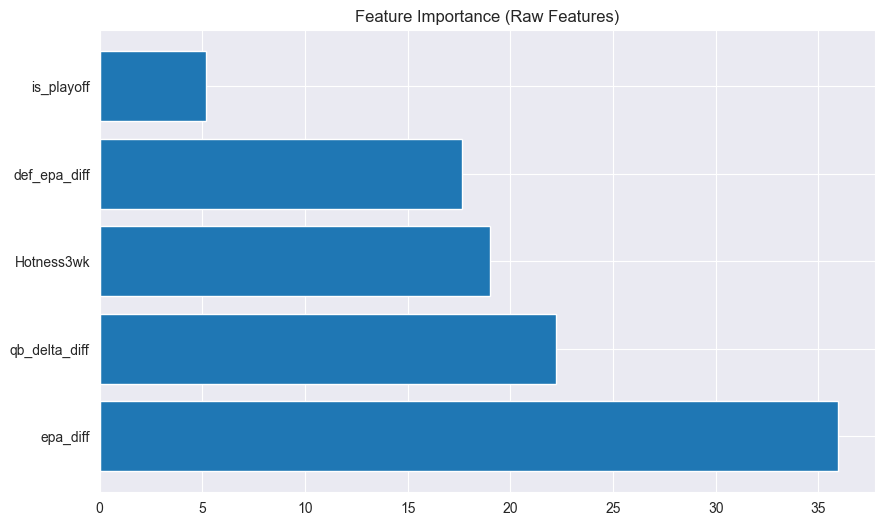

/var/folders/xz/n_0qz0kd7h710g99kc6r8h740000gn/T/ipykernel_53705/3138790812.py:102: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_error = weekly_error.groupby("week").apply(


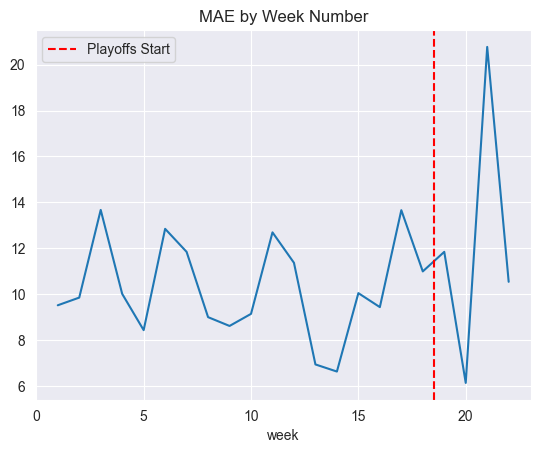

In [525]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# ======================
# DATA PREPARATION
# ======================
positions = ["qb", "rb", "wr", "te", "ol", "cb", "edge", "di"]
for pos in positions:
    game_data[f"{pos}_delta_diff"] = game_data[f"home_{pos}_delta"] - game_data[f"away_{pos}_delta"]

game_data["epa_diff"] = game_data["avg_home_team_epa"] - game_data["avg_away_team_epa"]
game_data["def_epa_diff"] = game_data["avg_home_def_epa"] - game_data["avg_away_def_epa"]
game_data["epa_diff_combo"] = game_data["epa_diff"] - game_data["def_epa_diff"]
game_data["Hotness_epaO"] = game_data["avg_home_off_epa_3week"] - game_data["avg_away_off_epa_3week"]
game_data["Hotness_epaD"] = game_data["avg_home_def_epa_3week"] - game_data["avg_away_def_epa_3week"]
game_data["Hotness3wk"] = game_data["Hotness_epaO"] - game_data["Hotness_epaD"]

# Fill NaNs in rolling 3-week features with 0 for early weeks (e.g. week 1)
fill_zero_cols = [
    "avg_home_off_epa_3week", "avg_away_off_epa_3week",
    "avg_home_def_epa_3week", "avg_away_def_epa_3week",
    "Hotness_epaO", "Hotness_epaD", "Hotness3wk"
]
game_data[fill_zero_cols] = game_data[fill_zero_cols].fillna(0)

game_data["is_playoff"] = (game_data["week"] > 18).astype(int)

game_data["point_diff"] = game_data["home_score"] - game_data["away_score"]
game_data["FPODIFF"] = game_data["avg_home_avg_starting_field_position"] - game_data["avg_away_avg_starting_field_position"]

# ======================
# FEATURE ENGINEERING
# ======================
feature_cols = [
    # Core metrics
    "is_playoff", "epa_diff", "def_epa_diff",
    # Raw deltas
    "qb_delta_diff",
    "Hotness3wk",

]

# ======================
# MODEL TRAINING
# ======================
train_df = game_data[game_data["season"].between(2021, 2023)].dropna(subset=feature_cols + ["point_diff"])
test_df = game_data[game_data["season"] == 2024].dropna(subset=feature_cols + ["point_diff"])

X_train, y_train = train_df[feature_cols], train_df["point_diff"]
X_test, y_test = test_df[feature_cols], test_df["point_diff"]

model = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.03,
    depth=5,
    loss_function='Quantile:alpha=0.5',  # quantile loss for median prediction
    eval_metric='MAE',
    early_stopping_rounds=50,
    verbose=100
)


model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    cat_features=["is_playoff"]
)

# ======================
# EVALUATION
# ======================
y_pred = model.predict(X_test)

print("\n=== Regular Season Games ===")
reg_mask = test_df["week"] <= 18
print(f"MAE: {mean_absolute_error(y_test[reg_mask], y_pred[reg_mask]):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test[reg_mask], y_pred[reg_mask])):.2f}")

print("\n=== Playoff Games ===")
playoff_mask = test_df["week"] > 18
print(f"MAE: {mean_absolute_error(y_test[playoff_mask], y_pred[playoff_mask]):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test[playoff_mask], y_pred[playoff_mask])):.2f}")

# ======================
# ANALYSIS
# ======================
fi = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.get_feature_importance()
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(fi['feature'], fi['importance'])
plt.title("Feature Importance (Raw Features)")
plt.show()

weekly_error = test_df.copy()
weekly_error["pred_diff"] = y_pred
weekly_error = weekly_error.groupby("week").apply(
    lambda x: mean_absolute_error(x["point_diff"], x["pred_diff"])
)
weekly_error.plot(title="MAE by Week Number")
plt.axvline(18.5, color='red', linestyle='--', label="Playoffs Start")
plt.legend()
plt.show()


In [526]:
# ======================
# PREDICTION ANALYSIS
# ======================
# Create DataFrame for comparison
pred_df = test_df[['game_id', 'season', 'week', 'home_team', 'away_team', 'home_score', 'away_score']].copy()
pred_df['pred_point_diff'] = y_pred
pred_df['actual_point_diff'] = y_test.values
pred_df['error'] = pred_df['pred_point_diff'] - pred_df['actual_point_diff']
pred_df['abs_error'] = np.abs(pred_df['error'])

# Add prediction direction accuracy
pred_df['correct_direction'] = np.sign(pred_df['pred_point_diff']) == np.sign(pred_df['actual_point_diff'])

# Show last 10 rows with predictions and actuals (most recent games)
print("\nLast 10 Game Predictions:")
print(pred_df[['season', 'week', 'home_team', 'away_team',
               'pred_point_diff', 'actual_point_diff', 'error',
               'correct_direction']].tail(30).round(1))

# Calculate and print directional accuracy
direction_accuracy = pred_df['correct_direction'].mean() * 100
print(f"\nDirectional Accuracy (Correct Winner Predicted): {direction_accuracy:.1f}%")

# Show worst predictions (largest absolute errors)
print("\nTop 5 Worst Predictions:")
print(pred_df.nlargest(5, 'abs_error')[['season', 'week', 'home_team', 'away_team',
                                      'pred_point_diff', 'actual_point_diff', 'error']].round(1))



Last 10 Game Predictions:
      season  week home_team away_team  pred_point_diff  actual_point_diff  \
1912    2024    17       JAX       TEN         2.400000           7.000000   
1913    2024    18        NE       BUF        -2.900000           7.000000   
1914    2024    18       ATL       CAR         7.400000          -6.000000   
1915    2024    18        GB       CHI        10.600000          -2.000000   
1916    2024    18       PIT       CIN        -1.200000          -2.000000   
1917    2024    18       BAL       CLE        11.200000          25.000000   
1918    2024    18       TEN       HOU        -3.300000          -9.000000   
1919    2024    18       IND       JAX        -0.300000           3.000000   
1920    2024    18       DEN        KC        -1.000000          38.000000   
1921    2024    18        LV       LAC        -2.600000         -14.000000   
1922    2024    18       NYJ       MIA        -0.000000          12.000000   
1923    2024    18       DET       MI

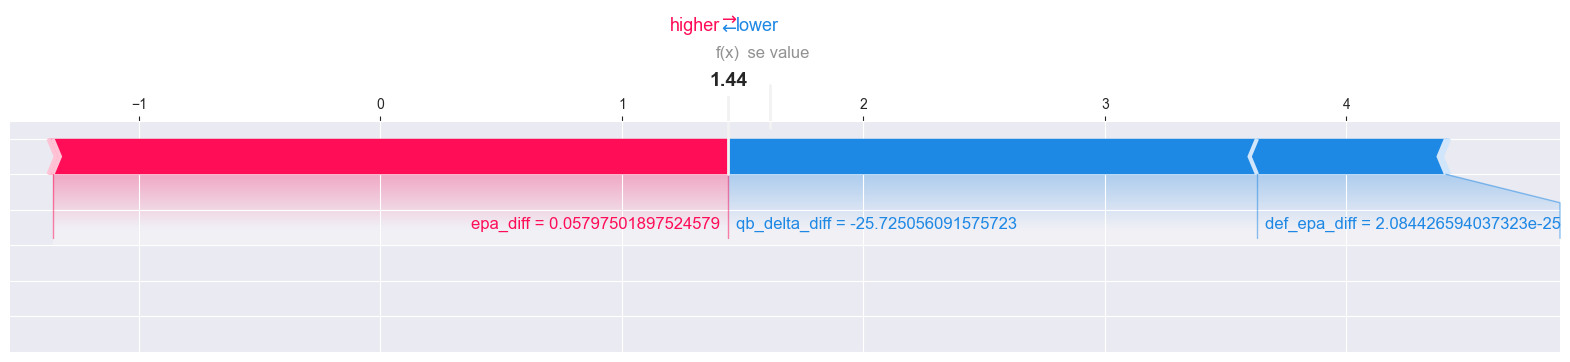

In [527]:
import shap
import matplotlib.pyplot as plt
from catboost import Pool

# Specify categorical features as used in training
cat_features = ["is_playoff"]

# Create Pool with categorical features
test_pool = Pool(X_test, cat_features=cat_features)

# Compute SHAP values for test set
shap_values = model.get_feature_importance(test_pool, type="ShapValues")

# Last column is expected value (baseline)
expected_value = shap_values[0, -1]

# Extract only feature contributions (drop last col)
shap_vals_only = shap_values[:, :-1]

# Choose the game_id you want to explain
game_id_to_explain = "2024_02_NYJ_TEN"

# Find the index of that game in test_df (and thus in X_test)
game_index = test_df.index.get_loc(test_df[test_df["game_id"] == game_id_to_explain].index[0])

# Visualize SHAP force plot for that game
shap.force_plot(
    expected_value,
    shap_vals_only[game_index, :],
    X_test.iloc[game_index, :],
    feature_names=feature_cols,
    matplotlib=True
)



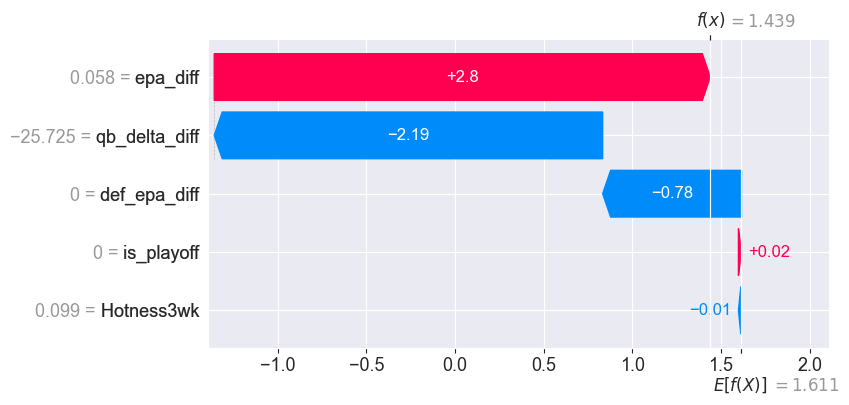

In [528]:
import shap

# For a single instance by game_index, get expected value and shap values
expected_value = shap_values[0, -1]
shap_values_single = shap_vals_only[game_index, :]

# Using shap's waterfall plot (recommended for vertical explanation)
shap.plots.waterfall(shap.Explanation(values=shap_values_single,
                                     base_values=expected_value,
                                     data=X_test.iloc[game_index],
                                     feature_names=feature_cols))


In [498]:
import pandas as pd

# Assuming y_pred is your array of predictions, and test_df has the actual results
results = test_df.copy()
results["prediction"] = y_pred

# Sort by prediction descending to see highest predicted spreads
top_preds = results.sort_values("prediction", ascending=False).head(10)
print(top_preds[["game_id", "prediction", "point_diff"]])


              game_id  prediction  point_diff
1808  2024_10_TEN_LAC   12.426612   10.000000
1889   2024_16_NE_BUF   11.508183    3.000000
1843    2024_13_LV_KC   10.842911    2.000000
1915   2024_18_CHI_GB   10.769276   -2.000000
1837  2024_13_CHI_DET   10.227930    3.000000
1835  2024_12_TEN_HOU   10.204830   -5.000000
1925  2024_18_NYG_PHI   10.190455    7.000000
1779  2024_08_TEN_DET   10.131539   38.000000
1790  2024_09_MIA_BUF    9.912573    3.000000
1781  2024_09_DAL_ATL    9.752167    6.000000


In [454]:
game_data.tail(5)

,game_id,home_team,away_team,home_plays,home_total_yards,home_total_epa,home_epa_per_play,home_pass_plays,home_rush_plays,home_pass_yards,home_rush_yards,home_third_down_conversions,home_third_down_failures,home_fourth_down_conversions,home_fourth_down_failures,home_penalties,home_interceptions,home_fumbles_lost,home_third_down_attempts,home_fourth_down_attempts,home_turnovers,home_yards_per_play,home_explosive_plays,home_red_zone_tds,home_sacks,home_dropbacks,home_avg_starting_field_position,home_total_penalties,home_sack_rate,home_penalties_per_play,away_plays,away_total_yards,away_total_epa,away_epa_per_play,away_pass_plays,away_rush_plays,away_pass_yards,away_rush_yards,away_third_down_conversions,away_third_down_failures,away_fourth_down_conversions,away_fourth_down_failures,away_penalties,away_interceptions,away_fumbles_lost,away_third_down_attempts,away_fourth_down_attempts,away_turnovers,away_yards_per_play,away_explosive_plays,away_red_zone_tds,away_sacks,away_dropbacks,away_avg_starting_field_position,away_total_penalties,away_sack_rate,away_penalties_per_play,home_explosive_plays_allowed,home_red_zone_tds_allowed,home_sacks_made,home_dropbacks_faced,home_avg_starting_field_position_allowed,home_total_penalties_by_defense,home_sack_rate_def,home_penalties_per_play_def,away_explosive_plays_allowed,away_red_zone_tds_allowed,away_sacks_made,away_dropbacks_faced,away_avg_starting_field_position_allowed,away_total_penalties_by_defense,away_sack_rate_def,away_penalties_per_play_def,home_score,away_score,season,week,home_avg_cb_score,home_avg_di_score,home_avg_edge_score,home_avg_lb_score,home_avg_ol_score,home_avg_qb_score,home_avg_rb_score,home_avg_s_score,home_avg_te_score,home_avg_wr_score,away_avg_cb_score,away_avg_di_score,away_avg_edge_score,away_avg_lb_score,away_avg_ol_score,away_avg_qb_score,away_avg_rb_score,away_avg_s_score,away_avg_te_score,away_avg_wr_score,home_cb_delta,home_di_delta,home_edge_delta,home_lb_delta,home_ol_delta,home_qb_delta,home_rb_delta,home_s_delta,home_te_delta,home_wr_delta,away_cb_delta,away_di_delta,away_edge_delta,away_lb_delta,away_ol_delta,away_qb_delta,away_rb_delta,away_s_delta,away_te_delta,away_wr_delta,avg_home_team_epa,avg_away_team_epa,avg_home_def_epa,avg_away_def_epa,home_off_minus_def,away_off_minus_def,avg_home_avg_starting_field_position,avg_away_avg_starting_field_position,avg_home_sack_rate,avg_away_sack_rate,avg_home_sack_rate_def,avg_away_sack_rate_def,qb_delta_diff,rb_delta_diff,wr_delta_diff,te_delta_diff,ol_delta_diff,cb_delta_diff,edge_delta_diff,di_delta_diff,epa_diff,def_epa_diff,point_diff,home_goodness,combined_epa_final,epa_diff_weighted,def_epa_diff_weighted,com_epa_diff,week_scaled,is_playoff,epa_playoff_boost,qb_delta_diff_weighted,rb_delta_diff_weighted,wr_delta_diff_weighted,te_delta_diff_weighted,ol_delta_diff_weighted,cb_delta_diff_weighted,edge_delta_diff_weighted,di_delta_diff_weighted,epa_diff_combo,point_diff_log,avg_home_off_epa_3week,avg_away_off_epa_3week,avg_home_def_epa_3week,avg_away_def_epa_3week,Hotness_epaO,Hotness_epaD,Hotness3wk
1937,2024_20_LA_PHI,PHI,LA,81,350.000000,5.732803,0.071660,27.000000,34.000000,128.000000,285.000000,6.000000,9.000000,1.000000,0.000000,4.000000,0.000000,0.000000,15.000000,1.000000,0.000000,4.320988,4,0,7.000000,30.000000,49.187500,4.000000,0.233333,0.049383,91,402.000000,-1.139857,-0.012526,49.000000,21.000000,324.000000,111.000000,6.000000,10.000000,1.000000,1.000000,2.000000,0.000000,2.000000,16.000000,2.000000,2.000000,4.417582,5,2,5.000000,50.000000,45.078651,2.000000,0.100000,0.021978,5,2,5.000000,50.000000,45.078651,2.000000,0.100000,0.040000,4,0,7.000000,30.000000,49.187500,4.000000,0.233333,0.133333,28.000000,22.000000,2024,20,58.801645,68.523767,60.797181,55.930940,64.048820,74.405300,64.046230,62.078916,53.860514,59.667934,63.458711,55.000000,65.694563,53.916773,58.912118,73.650419,66.283986,64.451224,55.664522,59.894671,-2.024097,1.955504,-12.578548,55.000000,-3.344899,0.000000,5.165651,-7.236580,-2

In [499]:
# Filter test_df for Jets as home or away team
jets_games = test_df[(test_df["home_team"] == "NYJ") | (test_df["away_team"] == "NYJ")].copy()

# Predict on Jets games features
jets_X = jets_games[feature_cols]
jets_preds = model.predict(jets_X)

# Add predictions to the dataframe
jets_games["pred_point_diff"] = jets_preds

# Show relevant columns: game_id, teams, week, actual and predicted point diff
print(jets_games[["game_id", "season", "week", "home_team", "away_team", "point_diff", "pred_point_diff"]])


              game_id  season  week home_team away_team  point_diff  \
1669   2024_01_NYJ_SF    2024     1        SF       NYJ   13.000000   
1684  2024_02_NYJ_TEN    2024     2       TEN       NYJ   -7.000000   
1700   2024_03_NE_NYJ    2024     3       NYJ        NE   21.000000   
1709  2024_04_DEN_NYJ    2024     4       NYJ       DEN   -1.000000   
1733  2024_05_NYJ_MIN    2024     5       MIN       NYJ    6.000000   
1737  2024_06_BUF_NYJ    2024     6       NYJ       BUF   -3.000000   
1760  2024_07_NYJ_PIT    2024     7       PIT       NYJ   22.000000   
1777   2024_08_NYJ_NE    2024     8        NE       NYJ    3.000000   
1784  2024_09_HOU_NYJ    2024     9       NYJ       HOU    8.000000   
1804  2024_10_NYJ_ARI    2024    10       ARI       NYJ   25.000000   
1815  2024_11_IND_NYJ    2024    11       NYJ       IND   -1.000000   
1848  2024_13_SEA_NYJ    2024    13       NYJ       SEA   -5.000000   
1863  2024_14_NYJ_MIA    2024    14       MIA       NYJ    6.000000   
1877  